# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=75,
        fold=3,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_18-36-07/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192215 [00:00<?, ?it/s]

  0%|          | 0/21143 [00:00<?, ?it/s]

  0%|          | 0/53294 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192215 [00:00<?, ?it/s]

  0%|          | 0/53294 [00:00<?, ?it/s]

  0%|          | 0/21143 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.4760 | MulticlassF1Score=0.2385
Batch-30 : CrossEntropyLoss=2.4988 | MulticlassF1Score=0.2489
Batch-45 : CrossEntropyLoss=2.5045 | MulticlassF1Score=0.2511
Batch-60 : CrossEntropyLoss=2.5292 | MulticlassF1Score=0.2534
Batch-75 : CrossEntropyLoss=2.5112 | MulticlassF1Score=0.2542
Batch-90 : CrossEntropyLoss=2.4749 | MulticlassF1Score=0.2555
Batch-105: CrossEntropyLoss=2.4336 | MulticlassF1Score=0.2659
Batch-120: CrossEntropyLoss=2.4278 | MulticlassF1Score=0.2795
Batch-135: CrossEntropyLoss=2.4881 | MulticlassF1Score=0.2904
Batch-150: CrossEntropyLoss=2.4441 | MulticlassF1Score=0.2991
Batch-165: CrossEntropyLoss=2.4452 | MulticlassF1Score=0.3059
Batch-180: CrossEntropyLoss=2.4647 | MulticlassF1Score=0.3117
Batch-195: CrossEntropyLoss=2.3996 | MulticlassF1Score=0.3216
Batch-210: CrossEntropyLoss=2.4110 | MulticlassF1Score=0.3328
Batch-225: CrossEntropyLoss=2.3895 | MulticlassF1Score=0.3468
Batch-226: CrossEntropyLoss=2.3816 | MulticlassF1Score=0.3474

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3896 | MulticlassF1Score=0.5724
Batch-30 : CrossEntropyLoss=2.3804 | MulticlassF1Score=0.5784
Batch-45 : CrossEntropyLoss=2.3726 | MulticlassF1Score=0.5824
Batch-60 : CrossEntropyLoss=2.3865 | MulticlassF1Score=0.5834
Batch-63 : CrossEntropyLoss=2.3747 | MulticlassF1Score=0.5830

Training   : Mean CrossEntropyLoss = 2.4615 | Mean MulticlassF1Score = 0.2801
Validation : Mean CrossEntropyLoss = 2.3799 | Mean MulticlassF1Score = 0.5789

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3887 | MulticlassF1Score=0.5849
Batch-30 : CrossEntropyLoss=2.3652 | MulticlassF1Score=0.5918
Batch-45 : CrossEntropyLoss=2.3527 | MulticlassF1Score=0.6131
Batch-60 : CrossEntropyLoss=2.3504 | MulticlassF1Score=0.6246
Batch-75 : CrossEntropyLoss=2.3617 | MulticlassF1Score=0.6343
Batch-90 : CrossEntropyLoss=2.3441 | MulticlassF1Score=0.6394
Batch-105: CrossEntropyLoss=2.3277 | MulticlassF1Score=0.6448
Batch-120: CrossEntropyLoss=2.3557 | MulticlassF1Score=0.6479
Batch-135: CrossEntropyLoss=2.3531 | MulticlassF1Score=0.6511
Batch-150: CrossEntropyLoss=2.3375 | MulticlassF1Score=0.6571
Batch-165: CrossEntropyLoss=2.3173 | MulticlassF1Score=0.6662
Batch-180: CrossEntropyLoss=2.3258 | MulticlassF1Score=0.6745
Batch-195: CrossEntropyLoss=2.3128 | MulticlassF1Score=0.6819
Batch-210: CrossEntropyLoss=2.3273 | MulticlassF1Score=0.6882
Batch-225: CrossEntropyLoss=2.3164 | MulticlassF1Score=0.6939
Batch-226: CrossEntropyLoss=2.3152 | MulticlassF1Score=0.6941

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3196 | MulticlassF1Score=0.7793
Batch-30 : CrossEntropyLoss=2.3136 | MulticlassF1Score=0.7808
Batch-45 : CrossEntropyLoss=2.3142 | MulticlassF1Score=0.7828
Batch-60 : CrossEntropyLoss=2.3180 | MulticlassF1Score=0.7848
Batch-63 : CrossEntropyLoss=2.3104 | MulticlassF1Score=0.7851

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3440 | Mean MulticlassF1Score = 0.6430
Validation : Mean CrossEntropyLoss = 2.3156 | Mean MulticlassF1Score = 0.7825

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3071 | MulticlassF1Score=0.7935
Batch-30 : CrossEntropyLoss=2.3126 | MulticlassF1Score=0.7914
Batch-45 : CrossEntropyLoss=2.3062 | MulticlassF1Score=0.7923
Batch-60 : CrossEntropyLoss=2.3280 | MulticlassF1Score=0.7924
Batch-75 : CrossEntropyLoss=2.3058 | MulticlassF1Score=0.7932
Batch-90 : CrossEntropyLoss=2.3183 | MulticlassF1Score=0.7933
Batch-105: CrossEntropyLoss=2.3086 | MulticlassF1Score=0.7935
Batch-120: CrossEntropyLoss=2.3151 | MulticlassF1Score=0.7934
Batch-135: CrossEntropyLoss=2.3099 | MulticlassF1Score=0.7943
Batch-150: CrossEntropyLoss=2.3095 | MulticlassF1Score=0.7938
Batch-165: CrossEntropyLoss=2.3166 | MulticlassF1Score=0.7939
Batch-180: CrossEntropyLoss=2.3172 | MulticlassF1Score=0.7940
Batch-195: CrossEntropyLoss=2.3117 | MulticlassF1Score=0.7939
Batch-210: CrossEntropyLoss=2.3161 | MulticlassF1Score=0.7937
Batch-225: CrossEntropyLoss=2.3088 | MulticlassF1Score=0.7935
Batch-226: CrossEntropyLoss=2.3171 | MulticlassF1Score=0.7935

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3043 | MulticlassF1Score=0.7913
Batch-30 : CrossEntropyLoss=2.2992 | MulticlassF1Score=0.7948
Batch-45 : CrossEntropyLoss=2.3124 | MulticlassF1Score=0.7955
Batch-60 : CrossEntropyLoss=2.3284 | MulticlassF1Score=0.7954
Batch-63 : CrossEntropyLoss=2.3242 | MulticlassF1Score=0.7947

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3123 | Mean MulticlassF1Score = 0.7930
Validation : Mean CrossEntropyLoss = 2.3116 | Mean MulticlassF1Score = 0.7936

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2997 | MulticlassF1Score=0.7987
Batch-30 : CrossEntropyLoss=2.2997 | MulticlassF1Score=0.7946
Batch-45 : CrossEntropyLoss=2.3161 | MulticlassF1Score=0.7936
Batch-60 : CrossEntropyLoss=2.3199 | MulticlassF1Score=0.7948
Batch-75 : CrossEntropyLoss=2.3145 | MulticlassF1Score=0.7947
Batch-90 : CrossEntropyLoss=2.2979 | MulticlassF1Score=0.7969
Batch-105: CrossEntropyLoss=2.3039 | MulticlassF1Score=0.7993
Batch-120: CrossEntropyLoss=2.3058 | MulticlassF1Score=0.8015
Batch-135: CrossEntropyLoss=2.3043 | MulticlassF1Score=0.8035
Batch-150: CrossEntropyLoss=2.3089 | MulticlassF1Score=0.8050
Batch-165: CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8064
Batch-180: CrossEntropyLoss=2.3069 | MulticlassF1Score=0.8075
Batch-195: CrossEntropyLoss=2.2997 | MulticlassF1Score=0.8081
Batch-210: CrossEntropyLoss=2.3071 | MulticlassF1Score=0.8085
Batch-225: CrossEntropyLoss=2.2979 | MulticlassF1Score=0.8091
Batch-226: CrossEntropyLoss=2.3068 | MulticlassF1Score=0.8092

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2992 | MulticlassF1Score=0.8189
Batch-30 : CrossEntropyLoss=2.3066 | MulticlassF1Score=0.8177
Batch-45 : CrossEntropyLoss=2.3029 | MulticlassF1Score=0.8177
Batch-60 : CrossEntropyLoss=2.3060 | MulticlassF1Score=0.8170
Batch-63 : CrossEntropyLoss=2.2982 | MulticlassF1Score=0.8173

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3071 | Mean MulticlassF1Score = 0.8006
Validation : Mean CrossEntropyLoss = 2.3044 | Mean MulticlassF1Score = 0.8179

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3098 | MulticlassF1Score=0.8203
Batch-30 : CrossEntropyLoss=2.3033 | MulticlassF1Score=0.8209
Batch-45 : CrossEntropyLoss=2.3023 | MulticlassF1Score=0.8200
Batch-60 : CrossEntropyLoss=2.3105 | MulticlassF1Score=0.8196
Batch-75 : CrossEntropyLoss=2.3040 | MulticlassF1Score=0.8197
Batch-90 : CrossEntropyLoss=2.3072 | MulticlassF1Score=0.8191
Batch-105: CrossEntropyLoss=2.3069 | MulticlassF1Score=0.8204
Batch-120: CrossEntropyLoss=2.2986 | MulticlassF1Score=0.8218
Batch-135: CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8229
Batch-150: CrossEntropyLoss=2.3038 | MulticlassF1Score=0.8242
Batch-165: CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8247
Batch-180: CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8252
Batch-195: CrossEntropyLoss=2.3052 | MulticlassF1Score=0.8256
Batch-210: CrossEntropyLoss=2.2987 | MulticlassF1Score=0.8256
Batch-225: CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8257
Batch-226: CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8258

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8247
Batch-30 : CrossEntropyLoss=2.3000 | MulticlassF1Score=0.8257
Batch-45 : CrossEntropyLoss=2.3067 | MulticlassF1Score=0.8294
Batch-60 : CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8291
Batch-63 : CrossEntropyLoss=2.3066 | MulticlassF1Score=0.8294

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3018 | Mean MulticlassF1Score = 0.8218
Validation : Mean CrossEntropyLoss = 2.3006 | Mean MulticlassF1Score = 0.8260

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3097 | MulticlassF1Score=0.8276
Batch-30 : CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8246
Batch-45 : CrossEntropyLoss=2.2943 | MulticlassF1Score=0.8263
Batch-60 : CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8268
Batch-75 : CrossEntropyLoss=2.3112 | MulticlassF1Score=0.8277
Batch-90 : CrossEntropyLoss=2.2946 | MulticlassF1Score=0.8299
Batch-105: CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8303
Batch-120: CrossEntropyLoss=2.3041 | MulticlassF1Score=0.8304
Batch-135: CrossEntropyLoss=2.3054 | MulticlassF1Score=0.8320
Batch-150: CrossEntropyLoss=2.3003 | MulticlassF1Score=0.8317
Batch-165: CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8321
Batch-180: CrossEntropyLoss=2.3023 | MulticlassF1Score=0.8327
Batch-195: CrossEntropyLoss=2.2983 | MulticlassF1Score=0.8331
Batch-210: CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8331
Batch-225: CrossEntropyLoss=2.3082 | MulticlassF1Score=0.8332
Batch-226: CrossEntropyLoss=2.3042 | MulticlassF1Score=0.8331

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2999 | MulticlassF1Score=0.8278
Batch-30 : CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8297
Batch-45 : CrossEntropyLoss=2.3024 | MulticlassF1Score=0.8291
Batch-60 : CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8299
Batch-63 : CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8298

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2995 | Mean MulticlassF1Score = 0.8301
Validation : Mean CrossEntropyLoss = 2.3004 | Mean MulticlassF1Score = 0.8275

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8319
Batch-30 : CrossEntropyLoss=2.3058 | MulticlassF1Score=0.8350
Batch-45 : CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8347
Batch-60 : CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8337
Batch-75 : CrossEntropyLoss=2.2915 | MulticlassF1Score=0.8350
Batch-90 : CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8346
Batch-105: CrossEntropyLoss=2.3022 | MulticlassF1Score=0.8350
Batch-120: CrossEntropyLoss=2.2987 | MulticlassF1Score=0.8356
Batch-135: CrossEntropyLoss=2.3092 | MulticlassF1Score=0.8345
Batch-150: CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8345
Batch-165: CrossEntropyLoss=2.3026 | MulticlassF1Score=0.8344
Batch-180: CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8342
Batch-195: CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8340
Batch-210: CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8352
Batch-225: CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8363
Batch-226: CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8363

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8388
Batch-30 : CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8438
Batch-45 : CrossEntropyLoss=2.3043 | MulticlassF1Score=0.8455
Batch-60 : CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8451
Batch-63 : CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8447

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2985 | Mean MulticlassF1Score = 0.8344
Validation : Mean CrossEntropyLoss = 2.2961 | Mean MulticlassF1Score = 0.8421

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8565
Batch-30 : CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8524
Batch-45 : CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8522
Batch-60 : CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8536
Batch-75 : CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8546
Batch-90 : CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8548
Batch-105: CrossEntropyLoss=2.2915 | MulticlassF1Score=0.8552
Batch-120: CrossEntropyLoss=2.2907 | MulticlassF1Score=0.8556
Batch-135: CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8553
Batch-150: CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8561
Batch-165: CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8561
Batch-180: CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8565
Batch-195: CrossEntropyLoss=2.2894 | MulticlassF1Score=0.8569
Batch-210: CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8572
Batch-225: CrossEntropyLoss=2.2952 | MulticlassF1Score=0.8577
Batch-226: CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8577

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8613
Batch-30 : CrossEntropyLoss=2.2998 | MulticlassF1Score=0.8563
Batch-45 : CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8558
Batch-60 : CrossEntropyLoss=2.3016 | MulticlassF1Score=0.8550
Batch-63 : CrossEntropyLoss=2.3032 | MulticlassF1Score=0.8555

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2921 | Mean MulticlassF1Score = 0.8552
Validation : Mean CrossEntropyLoss = 2.2927 | Mean MulticlassF1Score = 0.8572

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2928 | MulticlassF1Score=0.8620
Batch-30 : CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8629
Batch-45 : CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8636
Batch-60 : CrossEntropyLoss=2.2914 | MulticlassF1Score=0.8630
Batch-75 : CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8619
Batch-90 : CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8621
Batch-105: CrossEntropyLoss=2.2891 | MulticlassF1Score=0.8626
Batch-120: CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8622
Batch-135: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8619
Batch-150: CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8616
Batch-165: CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8616
Batch-180: CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8617
Batch-195: CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8613
Batch-210: CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8612
Batch-225: CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8610
Batch-226: CrossEntropyLoss=2.2894 | MulticlassF1Score=0.8611

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8488
Batch-30 : CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8543
Batch-45 : CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8550
Batch-60 : CrossEntropyLoss=2.3022 | MulticlassF1Score=0.8558
Batch-63 : CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8558

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2908 | Mean MulticlassF1Score = 0.8624
Validation : Mean CrossEntropyLoss = 2.2924 | Mean MulticlassF1Score = 0.8527

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8647
Batch-30 : CrossEntropyLoss=2.2986 | MulticlassF1Score=0.8655
Batch-45 : CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8639
Batch-60 : CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8635
Batch-75 : CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8627
Batch-90 : CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8636
Batch-105: CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8637
Batch-120: CrossEntropyLoss=2.2932 | MulticlassF1Score=0.8632
Batch-135: CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8629
Batch-150: CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8637
Batch-165: CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8635
Batch-180: CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8637
Batch-195: CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8632
Batch-210: CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8628
Batch-225: CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8624
Batch-226: CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8624

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3029 | MulticlassF1Score=0.8551
Batch-30 : CrossEntropyLoss=2.2891 | MulticlassF1Score=0.8574
Batch-45 : CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8563
Batch-60 : CrossEntropyLoss=2.2958 | MulticlassF1Score=0.8561
Batch-63 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8566

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2903 | Mean MulticlassF1Score = 0.8637
Validation : Mean CrossEntropyLoss = 2.2919 | Mean MulticlassF1Score = 0.8583

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8703
Batch-30 : CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8665
Batch-45 : CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8718
Batch-60 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.8747
Batch-75 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8779
Batch-90 : CrossEntropyLoss=2.2899 | MulticlassF1Score=0.8784
Batch-105: CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8792
Batch-120: CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8806
Batch-135: CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8811
Batch-150: CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8820
Batch-165: CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8834
Batch-180: CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8845
Batch-195: CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8848
Batch-210: CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8854
Batch-225: CrossEntropyLoss=2.2776 | MulticlassF1Score=0.8861
Batch-226: CrossEntropyLoss=2.2897 | MulticlassF1Score=0.8861

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8895
Batch-30 : CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8861
Batch-45 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8856
Batch-60 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8858
Batch-63 : CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8856

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2833 | Mean MulticlassF1Score = 0.8785
Validation : Mean CrossEntropyLoss = 2.2833 | Mean MulticlassF1Score = 0.8875

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2914 | MulticlassF1Score=0.8941
Batch-30 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.8952
Batch-45 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.8942
Batch-60 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.8941
Batch-75 : CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8945
Batch-90 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8953
Batch-105: CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8952
Batch-120: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.8952
Batch-135: CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8947
Batch-150: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8946
Batch-165: CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8946
Batch-180: CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8946
Batch-195: CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8944
Batch-210: CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8943
Batch-225: CrossEntropyLoss=2.2769 | MulticlassF1Score=0.8941
Batch-226: CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8941

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8933
Batch-30 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8879
Batch-45 : CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8870
Batch-60 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8875
Batch-63 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8874

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2807 | Mean MulticlassF1Score = 0.8945
Validation : Mean CrossEntropyLoss = 2.2826 | Mean MulticlassF1Score = 0.8888

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8987
Batch-30 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8959
Batch-45 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8976
Batch-60 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.8962
Batch-75 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.8953
Batch-90 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.8946
Batch-105: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.8946
Batch-120: CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8953
Batch-135: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.8956
Batch-150: CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8957
Batch-165: CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8958
Batch-180: CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8960
Batch-195: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.8964
Batch-210: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8968
Batch-225: CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8965
Batch-226: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8965

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8860
Batch-30 : CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8872
Batch-45 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8879
Batch-60 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8873
Batch-63 : CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8870

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2798 | Mean MulticlassF1Score = 0.8963
Validation : Mean CrossEntropyLoss = 2.2827 | Mean MulticlassF1Score = 0.8872

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.8961
Batch-30 : CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8979
Batch-45 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.8981
Batch-60 : CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8977
Batch-75 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.8982
Batch-90 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.8982
Batch-105: CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8982
Batch-120: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8987
Batch-135: CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8982
Batch-150: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.8978
Batch-165: CrossEntropyLoss=2.2755 | MulticlassF1Score=0.8980
Batch-180: CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8981
Batch-195: CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8984
Batch-210: CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8980
Batch-225: CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8979
Batch-226: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8978

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8890
Batch-30 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8878
Batch-45 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8878
Batch-60 : CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8875
Batch-63 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8878

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2793 | Mean MulticlassF1Score = 0.8979
Validation : Mean CrossEntropyLoss = 2.2824 | Mean MulticlassF1Score = 0.8870

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8979
Batch-30 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.8999
Batch-45 : CrossEntropyLoss=2.2795 | MulticlassF1Score=0.9000
Batch-60 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8996
Batch-75 : CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9001
Batch-90 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.9004
Batch-105: CrossEntropyLoss=2.2794 | MulticlassF1Score=0.9001
Batch-120: CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8991
Batch-135: CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8994
Batch-150: CrossEntropyLoss=2.2748 | MulticlassF1Score=0.8992
Batch-165: CrossEntropyLoss=2.2774 | MulticlassF1Score=0.8990
Batch-180: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.8989
Batch-195: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.8990
Batch-210: CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8993
Batch-225: CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8992
Batch-226: CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8990

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8881
Batch-30 : CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8866
Batch-45 : CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8869
Batch-60 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8880
Batch-63 : CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8881

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2789 | Mean MulticlassF1Score = 0.8997
Validation : Mean CrossEntropyLoss = 2.2823 | Mean MulticlassF1Score = 0.8871

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2863 | MulticlassF1Score=0.9021
Batch-30 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.9041
Batch-45 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.9038
Batch-60 : CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9034
Batch-75 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.9024
Batch-90 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.9021
Batch-105: CrossEntropyLoss=2.2793 | MulticlassF1Score=0.9015
Batch-120: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9012
Batch-135: CrossEntropyLoss=2.2793 | MulticlassF1Score=0.9009
Batch-150: CrossEntropyLoss=2.2779 | MulticlassF1Score=0.9006
Batch-165: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.9008
Batch-180: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9001
Batch-195: CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8998
Batch-210: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9001
Batch-225: CrossEntropyLoss=2.2795 | MulticlassF1Score=0.9002
Batch-226: CrossEntropyLoss=2.2801 | MulticlassF1Score=0.9002

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8851
Batch-30 : CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8845
Batch-45 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8867
Batch-60 : CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8886
Batch-63 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8886

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2785 | Mean MulticlassF1Score = 0.9021
Validation : Mean CrossEntropyLoss = 2.2821 | Mean MulticlassF1Score = 0.8859

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9015
Batch-30 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9019
Batch-45 : CrossEntropyLoss=2.2852 | MulticlassF1Score=0.9000
Batch-60 : CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8997
Batch-75 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9006
Batch-90 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.9000
Batch-105: CrossEntropyLoss=2.2837 | MulticlassF1Score=0.9017
Batch-120: CrossEntropyLoss=2.2882 | MulticlassF1Score=0.9017
Batch-135: CrossEntropyLoss=2.2837 | MulticlassF1Score=0.9019
Batch-150: CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9015
Batch-165: CrossEntropyLoss=2.2835 | MulticlassF1Score=0.9019
Batch-180: CrossEntropyLoss=2.2826 | MulticlassF1Score=0.9015
Batch-195: CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9011
Batch-210: CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9011
Batch-225: CrossEntropyLoss=2.2797 | MulticlassF1Score=0.9007
Batch-226: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.9007

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8871
Batch-30 : CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8881
Batch-45 : CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8894
Batch-60 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.8885
Batch-63 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8887

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2783 | Mean MulticlassF1Score = 0.9013
Validation : Mean CrossEntropyLoss = 2.2820 | Mean MulticlassF1Score = 0.8882

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9016
Batch-30 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9009
Batch-45 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.9019
Batch-60 : CrossEntropyLoss=2.2795 | MulticlassF1Score=0.9022
Batch-75 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.9022
Batch-90 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9025
Batch-105: CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9027
Batch-120: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9024
Batch-135: CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9019
Batch-150: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9020
Batch-165: CrossEntropyLoss=2.2805 | MulticlassF1Score=0.9020
Batch-180: CrossEntropyLoss=2.2805 | MulticlassF1Score=0.9020
Batch-195: CrossEntropyLoss=2.2901 | MulticlassF1Score=0.9014
Batch-210: CrossEntropyLoss=2.2831 | MulticlassF1Score=0.9012
Batch-225: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9013
Batch-226: CrossEntropyLoss=2.2827 | MulticlassF1Score=0.9012

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8918
Batch-30 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.8919
Batch-45 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8905
Batch-60 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8891
Batch-63 : CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8893

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2781 | Mean MulticlassF1Score = 0.9017
Validation : Mean CrossEntropyLoss = 2.2818 | Mean MulticlassF1Score = 0.8905

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8979
Batch-30 : CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8974
Batch-45 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.8997
Batch-60 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.8996
Batch-75 : CrossEntropyLoss=2.2822 | MulticlassF1Score=0.9005
Batch-90 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.9005
Batch-105: CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9006
Batch-120: CrossEntropyLoss=2.2855 | MulticlassF1Score=0.9008
Batch-135: CrossEntropyLoss=2.2849 | MulticlassF1Score=0.9008
Batch-150: CrossEntropyLoss=2.2819 | MulticlassF1Score=0.9005
Batch-165: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9006
Batch-180: CrossEntropyLoss=2.2823 | MulticlassF1Score=0.9009
Batch-195: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9015
Batch-210: CrossEntropyLoss=2.2828 | MulticlassF1Score=0.9018
Batch-225: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9014
Batch-226: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9014

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.8854
Batch-30 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8895
Batch-45 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8897
Batch-60 : CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8888
Batch-63 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8891

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2781 | Mean MulticlassF1Score = 0.9004
Validation : Mean CrossEntropyLoss = 2.2819 | Mean MulticlassF1Score = 0.8890

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9036
Batch-30 : CrossEntropyLoss=2.2817 | MulticlassF1Score=0.9021
Batch-45 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9025
Batch-60 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9027
Batch-75 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9017
Batch-90 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.9011
Batch-105: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9019
Batch-120: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9012
Batch-135: CrossEntropyLoss=2.2821 | MulticlassF1Score=0.9016
Batch-150: CrossEntropyLoss=2.2796 | MulticlassF1Score=0.9019
Batch-165: CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9014
Batch-180: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9017
Batch-195: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9020
Batch-210: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9021
Batch-225: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9024
Batch-226: CrossEntropyLoss=2.2787 | MulticlassF1Score=0.9024

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8943
Batch-30 : CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8918
Batch-45 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8911
Batch-60 : CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8903
Batch-63 : CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8901

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2777 | Mean MulticlassF1Score = 0.9022
Validation : Mean CrossEntropyLoss = 2.2816 | Mean MulticlassF1Score = 0.8930

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9031
Batch-30 : CrossEntropyLoss=2.2849 | MulticlassF1Score=0.9041
Batch-45 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9035
Batch-60 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.9030
Batch-75 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9027
Batch-90 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.9028
Batch-105: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9027
Batch-120: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9025
Batch-135: CrossEntropyLoss=2.2801 | MulticlassF1Score=0.9023
Batch-150: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9035
Batch-165: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9041
Batch-180: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9045
Batch-195: CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9049
Batch-210: CrossEntropyLoss=2.2787 | MulticlassF1Score=0.9053
Batch-225: CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9053
Batch-226: CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9053

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8968
Batch-30 : CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8953
Batch-45 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8952
Batch-60 : CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8949
Batch-63 : CrossEntropyLoss=2.2869 | MulticlassF1Score=0.8943

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2769 | Mean MulticlassF1Score = 0.9037
Validation : Mean CrossEntropyLoss = 2.2803 | Mean MulticlassF1Score = 0.8953

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9116
Batch-30 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9128
Batch-45 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.9110
Batch-60 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9108
Batch-75 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.9101
Batch-90 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.9098
Batch-105: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9101
Batch-120: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9096
Batch-135: CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9093
Batch-150: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9095
Batch-165: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9098
Batch-180: CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9098
Batch-195: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9097
Batch-210: CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9094
Batch-225: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9092
Batch-226: CrossEntropyLoss=2.2794 | MulticlassF1Score=0.9092

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8886
Batch-30 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8908
Batch-45 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8943
Batch-60 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.8954
Batch-63 : CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8956

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2757 | Mean MulticlassF1Score = 0.9103
Validation : Mean CrossEntropyLoss = 2.2800 | Mean MulticlassF1Score = 0.8921

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9124
Batch-30 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9131
Batch-45 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9189
Batch-60 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9234
Batch-75 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9244
Batch-90 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9254
Batch-105: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9260
Batch-120: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9264
Batch-135: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9268
Batch-150: CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9270
Batch-165: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9275
Batch-180: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9281
Batch-195: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9284
Batch-210: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9291
Batch-225: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9295
Batch-226: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9295

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9186
Batch-30 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9179
Batch-45 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9184
Batch-60 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9191
Batch-63 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9193

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2695 | Mean MulticlassF1Score = 0.9239
Validation : Mean CrossEntropyLoss = 2.2727 | Mean MulticlassF1Score = 0.9171

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9310
Batch-30 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9329
Batch-45 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9346
Batch-60 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9344
Batch-75 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9351
Batch-90 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9358
Batch-105: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9365
Batch-120: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9366
Batch-135: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9363
Batch-150: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9367
Batch-165: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9371
Batch-180: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9376
Batch-195: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9378
Batch-210: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9379
Batch-225: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9378
Batch-226: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9378

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9247
Batch-30 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9238
Batch-45 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9247
Batch-60 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9240
Batch-63 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9239

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2670 | Mean MulticlassF1Score = 0.9358
Validation : Mean CrossEntropyLoss = 2.2712 | Mean MulticlassF1Score = 0.9241

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9402
Batch-30 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9406
Batch-45 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9407
Batch-60 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9399
Batch-75 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9408
Batch-90 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9413
Batch-105: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9413
Batch-120: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9417
Batch-135: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9415
Batch-150: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9418
Batch-165: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9419
Batch-180: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9417
Batch-195: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9416
Batch-210: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9415
Batch-225: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9413
Batch-226: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9413

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9215
Batch-30 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9228
Batch-45 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9232
Batch-60 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9243
Batch-63 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9241

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2658 | Mean MulticlassF1Score = 0.9412
Validation : Mean CrossEntropyLoss = 2.2710 | Mean MulticlassF1Score = 0.9217

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9392
Batch-30 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9401
Batch-45 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9409
Batch-60 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9421
Batch-75 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9420
Batch-90 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9423
Batch-105: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9426
Batch-120: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9428
Batch-135: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9428
Batch-150: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9423
Batch-165: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9425
Batch-180: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9430
Batch-195: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9429
Batch-210: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9432
Batch-225: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9432
Batch-226: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9432

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9257
Batch-30 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9269
Batch-45 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9264
Batch-60 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9264
Batch-63 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9268

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2652 | Mean MulticlassF1Score = 0.9422
Validation : Mean CrossEntropyLoss = 2.2702 | Mean MulticlassF1Score = 0.9265

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9465
Batch-30 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9462
Batch-45 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9449
Batch-60 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9454
Batch-75 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9452
Batch-90 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9452
Batch-105: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9457
Batch-120: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9451
Batch-135: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9449
Batch-150: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9441
Batch-165: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9446
Batch-180: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9446
Batch-195: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9448
Batch-210: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9449
Batch-225: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9445
Batch-226: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9445

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9311
Batch-30 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9264
Batch-45 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9269
Batch-60 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9276
Batch-63 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9275

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2647 | Mean MulticlassF1Score = 0.9450
Validation : Mean CrossEntropyLoss = 2.2701 | Mean MulticlassF1Score = 0.9292

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9478
Batch-30 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9472
Batch-45 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9470
Batch-60 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9476
Batch-75 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9474
Batch-90 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9472
Batch-105: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9474
Batch-120: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9469
Batch-135: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9467
Batch-150: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9466
Batch-165: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9464
Batch-180: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9464
Batch-195: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9463
Batch-210: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9464
Batch-225: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9463
Batch-226: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9463

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9271
Batch-30 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9284
Batch-45 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9286
Batch-60 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9282
Batch-63 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9284

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9468
Validation : Mean CrossEntropyLoss = 2.2698 | Mean MulticlassF1Score = 0.9273

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9455
Batch-30 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9456
Batch-45 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9469
Batch-60 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9472
Batch-75 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9468
Batch-90 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9467
Batch-105: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9468
Batch-120: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9468
Batch-135: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9470
Batch-150: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9470
Batch-165: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9467
Batch-180: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9470
Batch-195: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9470
Batch-210: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9473
Batch-225: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9469
Batch-226: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9469

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9278
Batch-30 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9269
Batch-45 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9276
Batch-60 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9293
Batch-63 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9291

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9467
Validation : Mean CrossEntropyLoss = 2.2694 | Mean MulticlassF1Score = 0.9282

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9456
Batch-30 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9473
Batch-45 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9474
Batch-60 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9478
Batch-75 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9473
Batch-90 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9472
Batch-105: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9473
Batch-120: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9473
Batch-135: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9473
Batch-150: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9471
Batch-165: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9472
Batch-180: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9473
Batch-195: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9475
Batch-210: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9475
Batch-225: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9475
Batch-226: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9475

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9318
Batch-30 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9329
Batch-45 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9311
Batch-60 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9292
Batch-63 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9290

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9474
Validation : Mean CrossEntropyLoss = 2.2695 | Mean MulticlassF1Score = 0.9314

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9499
Batch-30 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9507
Batch-45 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9505
Batch-60 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9500
Batch-75 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9486
Batch-90 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9485
Batch-105: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9483
Batch-120: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9479
Batch-135: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9479
Batch-150: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9477
Batch-165: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9476
Batch-180: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9475
Batch-195: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9476
Batch-210: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9478
Batch-225: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9477
Batch-226: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9477

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9258
Batch-30 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9260
Batch-45 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9269
Batch-60 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9271
Batch-63 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9273

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9485
Validation : Mean CrossEntropyLoss = 2.2700 | Mean MulticlassF1Score = 0.9259

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9471
Batch-30 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9490
Batch-45 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9486
Batch-60 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9486
Batch-75 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9490
Batch-90 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9489
Batch-105: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9489
Batch-120: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9487
Batch-135: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9482
Batch-150: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9484
Batch-165: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9482
Batch-180: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9482
Batch-195: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9485
Batch-210: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9482
Batch-225: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9482
Batch-226: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9481

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9332
Batch-30 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9307
Batch-45 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9294
Batch-60 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9279
Batch-63 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9283

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9483
Validation : Mean CrossEntropyLoss = 2.2697 | Mean MulticlassF1Score = 0.9315

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9487
Batch-30 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9468
Batch-45 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9459
Batch-60 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9470
Batch-75 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9474
Batch-90 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9473
Batch-105: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9475
Batch-120: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9477
Batch-135: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9477
Batch-150: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9481
Batch-165: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9481
Batch-180: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9481
Batch-195: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9482
Batch-210: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9483
Batch-225: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9486
Batch-226: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9486

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9385
Batch-30 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9403
Batch-45 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9429
Batch-60 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9423
Batch-63 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9424

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9477
Validation : Mean CrossEntropyLoss = 2.2659 | Mean MulticlassF1Score = 0.9406

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9679
Batch-30 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9673
Batch-45 : CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9675
Batch-60 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9671
Batch-75 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9672
Batch-90 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9673
Batch-105: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9669
Batch-120: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9670
Batch-135: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9670
Batch-150: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9671
Batch-165: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9671
Batch-180: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9672
Batch-195: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9673
Batch-210: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9674
Batch-225: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9673
Batch-226: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9673

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9477
Batch-30 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9489
Batch-45 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9478
Batch-60 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9478
Batch-63 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9476

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2578 | Mean MulticlassF1Score = 0.9673
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9478

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9665
Batch-30 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9689
Batch-45 : CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9701
Batch-60 : CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9701
Batch-75 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9694
Batch-90 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9690
Batch-105: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9684
Batch-120: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9684
Batch-135: CrossEntropyLoss=2.2523 | MulticlassF1Score=0.9684
Batch-150: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9685
Batch-165: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9685
Batch-180: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9685
Batch-195: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9684
Batch-210: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9683
Batch-225: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9681
Batch-226: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9682

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9506
Batch-30 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9493
Batch-45 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9470
Batch-60 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9482
Batch-63 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9483

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2574 | Mean MulticlassF1Score = 0.9684
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9491

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9698
Batch-30 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9696
Batch-45 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9693
Batch-60 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9691
Batch-75 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9689
Batch-90 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9690
Batch-105: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9691
Batch-120: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9692
Batch-135: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9694
Batch-150: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9690
Batch-165: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9690
Batch-180: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9691
Batch-195: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9689
Batch-210: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9689
Batch-225: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9688
Batch-226: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9688

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9477
Batch-30 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9480
Batch-45 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9475
Batch-60 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9486
Batch-63 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9486

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2572 | Mean MulticlassF1Score = 0.9691
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9484

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9680
Batch-30 : CrossEntropyLoss=2.2527 | MulticlassF1Score=0.9699
Batch-45 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9699
Batch-60 : CrossEntropyLoss=2.2527 | MulticlassF1Score=0.9699
Batch-75 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9698
Batch-90 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9698
Batch-105: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9699
Batch-120: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9696
Batch-135: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9698
Batch-150: CrossEntropyLoss=2.2527 | MulticlassF1Score=0.9698
Batch-165: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9697
Batch-180: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9696
Batch-195: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9696
Batch-210: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9694
Batch-225: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9691
Batch-226: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9691

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9458
Batch-30 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9482
Batch-45 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9481
Batch-60 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9484
Batch-63 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9485

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9696
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9475

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9684
Batch-30 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9678
Batch-45 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9695
Batch-60 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9694
Batch-75 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9692
Batch-90 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9694
Batch-105: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9695
Batch-120: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9692
Batch-135: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9693
Batch-150: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9692
Batch-165: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9694
Batch-180: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9691
Batch-195: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9691
Batch-210: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9693
Batch-225: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9693
Batch-226: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9693

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9472
Batch-30 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9471
Batch-45 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9482
Batch-60 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9483
Batch-63 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9481

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9692
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9478

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9685
Batch-30 : CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9701
Batch-45 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9697
Batch-60 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9687
Batch-75 : CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9687
Batch-90 : CrossEntropyLoss=2.2526 | MulticlassF1Score=0.9691
Batch-105: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9692
Batch-120: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9693
Batch-135: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9691
Batch-150: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9694
Batch-165: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9694
Batch-180: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9694
Batch-195: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9693
Batch-210: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9694
Batch-225: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9694
Batch-226: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9694

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9524
Batch-30 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9500
Batch-45 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9483
Batch-60 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9488
Batch-63 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9491

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2569 | Mean MulticlassF1Score = 0.9693
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9497

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9688
Batch-30 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9695
Batch-45 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9705
Batch-60 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9705
Batch-75 : CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9706
Batch-90 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9709
Batch-105: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9704
Batch-120: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9700
Batch-135: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9696
Batch-150: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9696
Batch-165: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9693
Batch-180: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9695
Batch-195: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9696
Batch-210: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9695
Batch-225: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9693
Batch-226: CrossEntropyLoss=2.2513 | MulticlassF1Score=0.9694

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9486
Batch-30 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9486
Batch-45 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9483
Batch-60 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9475
Batch-63 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9475

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2569 | Mean MulticlassF1Score = 0.9698
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9481
Patience = 1/50❗

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9698
Batch-30 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9694
Batch-45 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9676
Batch-60 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9681
Batch-75 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9679
Batch-90 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9680
Batch-105: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9683
Batch-120: CrossEntropyLoss=2.2531 | MulticlassF1Score=0.9688
Batch-135: CrossEntropyLoss=2.2521 | MulticlassF1Score=0.9690
Batch-150: CrossEntropyLoss=2.2520 | MulticlassF1Score=0.9689
Batch-165: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9689
Batch-180: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9687
Batch-195: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9690
Batch-210: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9691
Batch-225: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9692
Batch-226: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9692

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9472
Batch-30 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9475
Batch-45 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9470
Batch-60 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9472
Batch-63 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9473

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9687
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9476
Patience = 2/50❗

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9685
Batch-30 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9674
Batch-45 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9669
Batch-60 : CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9676
Batch-75 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9677
Batch-90 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9679
Batch-105: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9669
Batch-120: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9671
Batch-135: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9671
Batch-150: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9670
Batch-165: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9670
Batch-180: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9670
Batch-195: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9670
Batch-210: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9670
Batch-225: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9671
Batch-226: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9671

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9472
Batch-30 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9461
Batch-45 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9465
Batch-60 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9480
Batch-63 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9480

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2578 | Mean MulticlassF1Score = 0.9673
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9470
Patience = 3/50❗

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9686
Batch-30 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9702
Batch-45 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9701
Batch-60 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9701
Batch-75 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9701
Batch-90 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9706
Batch-105: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9703
Batch-120: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9701
Batch-135: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9695
Batch-150: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9693
Batch-165: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9692
Batch-180: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9692
Batch-195: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9690
Batch-210: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9689
Batch-225: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9688
Batch-226: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9688

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9475
Batch-30 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9478
Batch-45 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9481
Batch-60 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9481
Batch-63 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9484

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2572 | Mean MulticlassF1Score = 0.9697
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9472

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9712
Batch-30 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9712
Batch-45 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9717
Batch-60 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9714
Batch-75 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9708
Batch-90 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9711
Batch-105: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9703
Batch-120: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9704
Batch-135: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9702
Batch-150: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9699
Batch-165: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9699
Batch-180: CrossEntropyLoss=2.2530 | MulticlassF1Score=0.9699
Batch-195: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9701
Batch-210: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9701
Batch-225: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9700
Batch-226: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9700

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9473
Batch-30 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9462
Batch-45 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9468
Batch-60 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9479
Batch-63 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9481

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2567 | Mean MulticlassF1Score = 0.9704
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9457

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9710
Batch-30 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9699
Batch-45 : CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9705
Batch-60 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9698
Batch-75 : CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9702
Batch-90 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9705
Batch-105: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9704
Batch-120: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9705
Batch-135: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9706
Batch-150: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9703
Batch-165: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9705
Batch-180: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9702
Batch-195: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9702
Batch-210: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9704
Batch-225: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9706
Batch-226: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9706

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9459
Batch-30 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9474
Batch-45 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9476
Batch-60 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9478
Batch-63 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9481

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2565 | Mean MulticlassF1Score = 0.9704
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9474

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9693
Batch-30 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9706
Batch-45 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9714
Batch-60 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9712
Batch-75 : CrossEntropyLoss=2.2514 | MulticlassF1Score=0.9720
Batch-90 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9722
Batch-105: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9717
Batch-120: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9714
Batch-135: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9711
Batch-150: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9709
Batch-165: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9708
Batch-180: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9709
Batch-195: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9710
Batch-210: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9709
Batch-225: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9710
Batch-226: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9710

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9485
Batch-30 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9499
Batch-45 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9494
Batch-60 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9482
Batch-63 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9483

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2563 | Mean MulticlassF1Score = 0.9709
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9484

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9708
Batch-30 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9713
Batch-45 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9705
Batch-60 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9707
Batch-75 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9707
Batch-90 : CrossEntropyLoss=2.2525 | MulticlassF1Score=0.9705
Batch-105: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9707
Batch-120: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9710
Batch-135: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9709
Batch-150: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9712
Batch-165: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9712
Batch-180: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9711
Batch-195: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9709
Batch-210: CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9711
Batch-225: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9712
Batch-226: CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9712

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9519
Batch-30 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9522
Batch-45 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9489
Batch-60 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9493
Batch-63 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9487

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2563 | Mean MulticlassF1Score = 0.9709
Validation : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9510

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9700
Batch-30 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9703
Batch-45 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9706
Batch-60 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9710
Batch-75 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9706
Batch-90 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9709
Batch-105: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9715
Batch-120: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9718
Batch-135: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9716
Batch-150: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9714
Batch-165: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9713
Batch-180: CrossEntropyLoss=2.2520 | MulticlassF1Score=0.9713
Batch-195: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9713
Batch-210: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9714
Batch-225: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9712
Batch-226: CrossEntropyLoss=2.2523 | MulticlassF1Score=0.9712

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9485
Batch-30 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9502
Batch-45 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9489
Batch-60 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9489
Batch-63 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9487

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2562 | Mean MulticlassF1Score = 0.9709
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9484

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9726
Batch-30 : CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9719
Batch-45 : CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9723
Batch-60 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9719
Batch-75 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9717
Batch-90 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9714
Batch-105: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9711
Batch-120: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9711
Batch-135: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9713
Batch-150: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9714
Batch-165: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9715
Batch-180: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9716
Batch-195: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9715
Batch-210: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9715
Batch-225: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9712
Batch-226: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9712

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9439
Batch-30 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9453
Batch-45 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9462
Batch-60 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9476
Batch-63 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9482

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2563 | Mean MulticlassF1Score = 0.9717
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9453
Patience = 4/50❗

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9702
Batch-30 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9709
Batch-45 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9718
Batch-60 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9710
Batch-75 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9713
Batch-90 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9710
Batch-105: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9712
Batch-120: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9710
Batch-135: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9709
Batch-150: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9710
Batch-165: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9710
Batch-180: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9709
Batch-195: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9708
Batch-210: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9709
Batch-225: CrossEntropyLoss=2.2522 | MulticlassF1Score=0.9707
Batch-226: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9707

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9468
Batch-30 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9496
Batch-45 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9493
Batch-60 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9479
Batch-63 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9480

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2564 | Mean MulticlassF1Score = 0.9710
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9478
Patience = 5/50❗

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2562
Best CrossEntropyLoss training    : 2.2634
Best MulticlassF1Score validation : 0.9709
Best MulticlassF1Score validation : 0.9484
Training duration                 : 2.0147 minutes.
Training date                     : 2022-10-19 13:07:04.791626+08:00


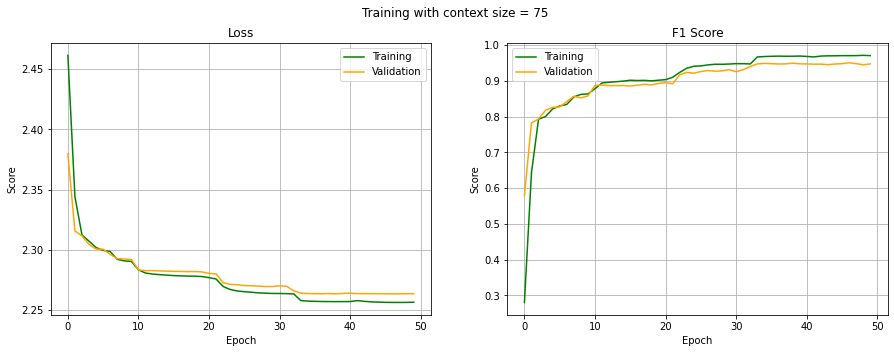

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9713, device='cuda:0'),
 tensor(0.9480, device='cuda:0'),
 tensor(0.9466, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9713, device='cuda:0'),
 tensor(0.9480, device='cuda:0'),
 tensor(0.9466, device='cuda:0'))

## Heatmap

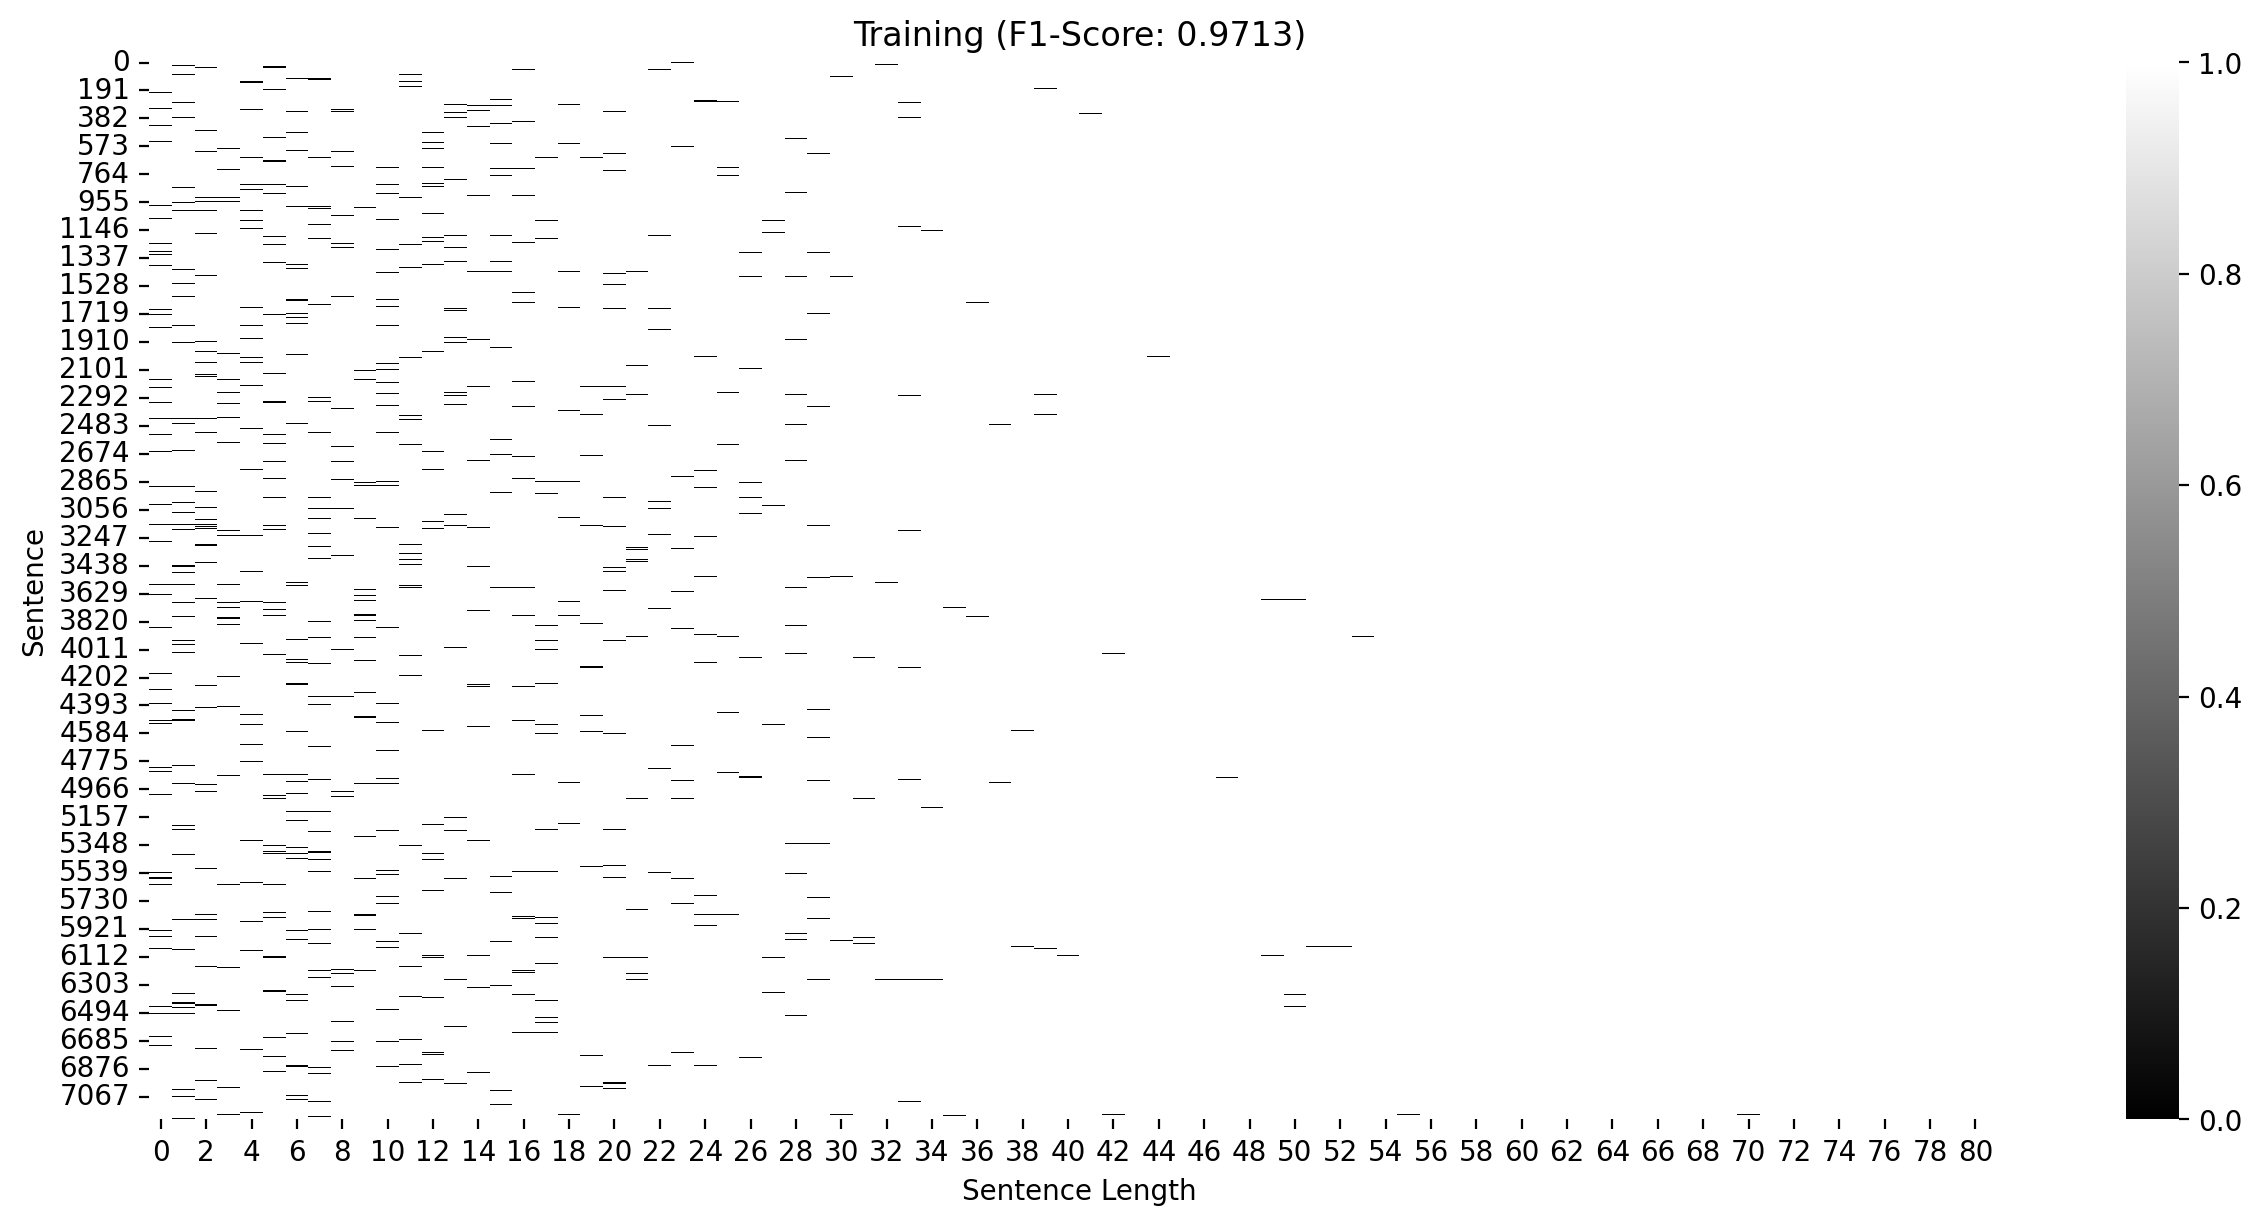

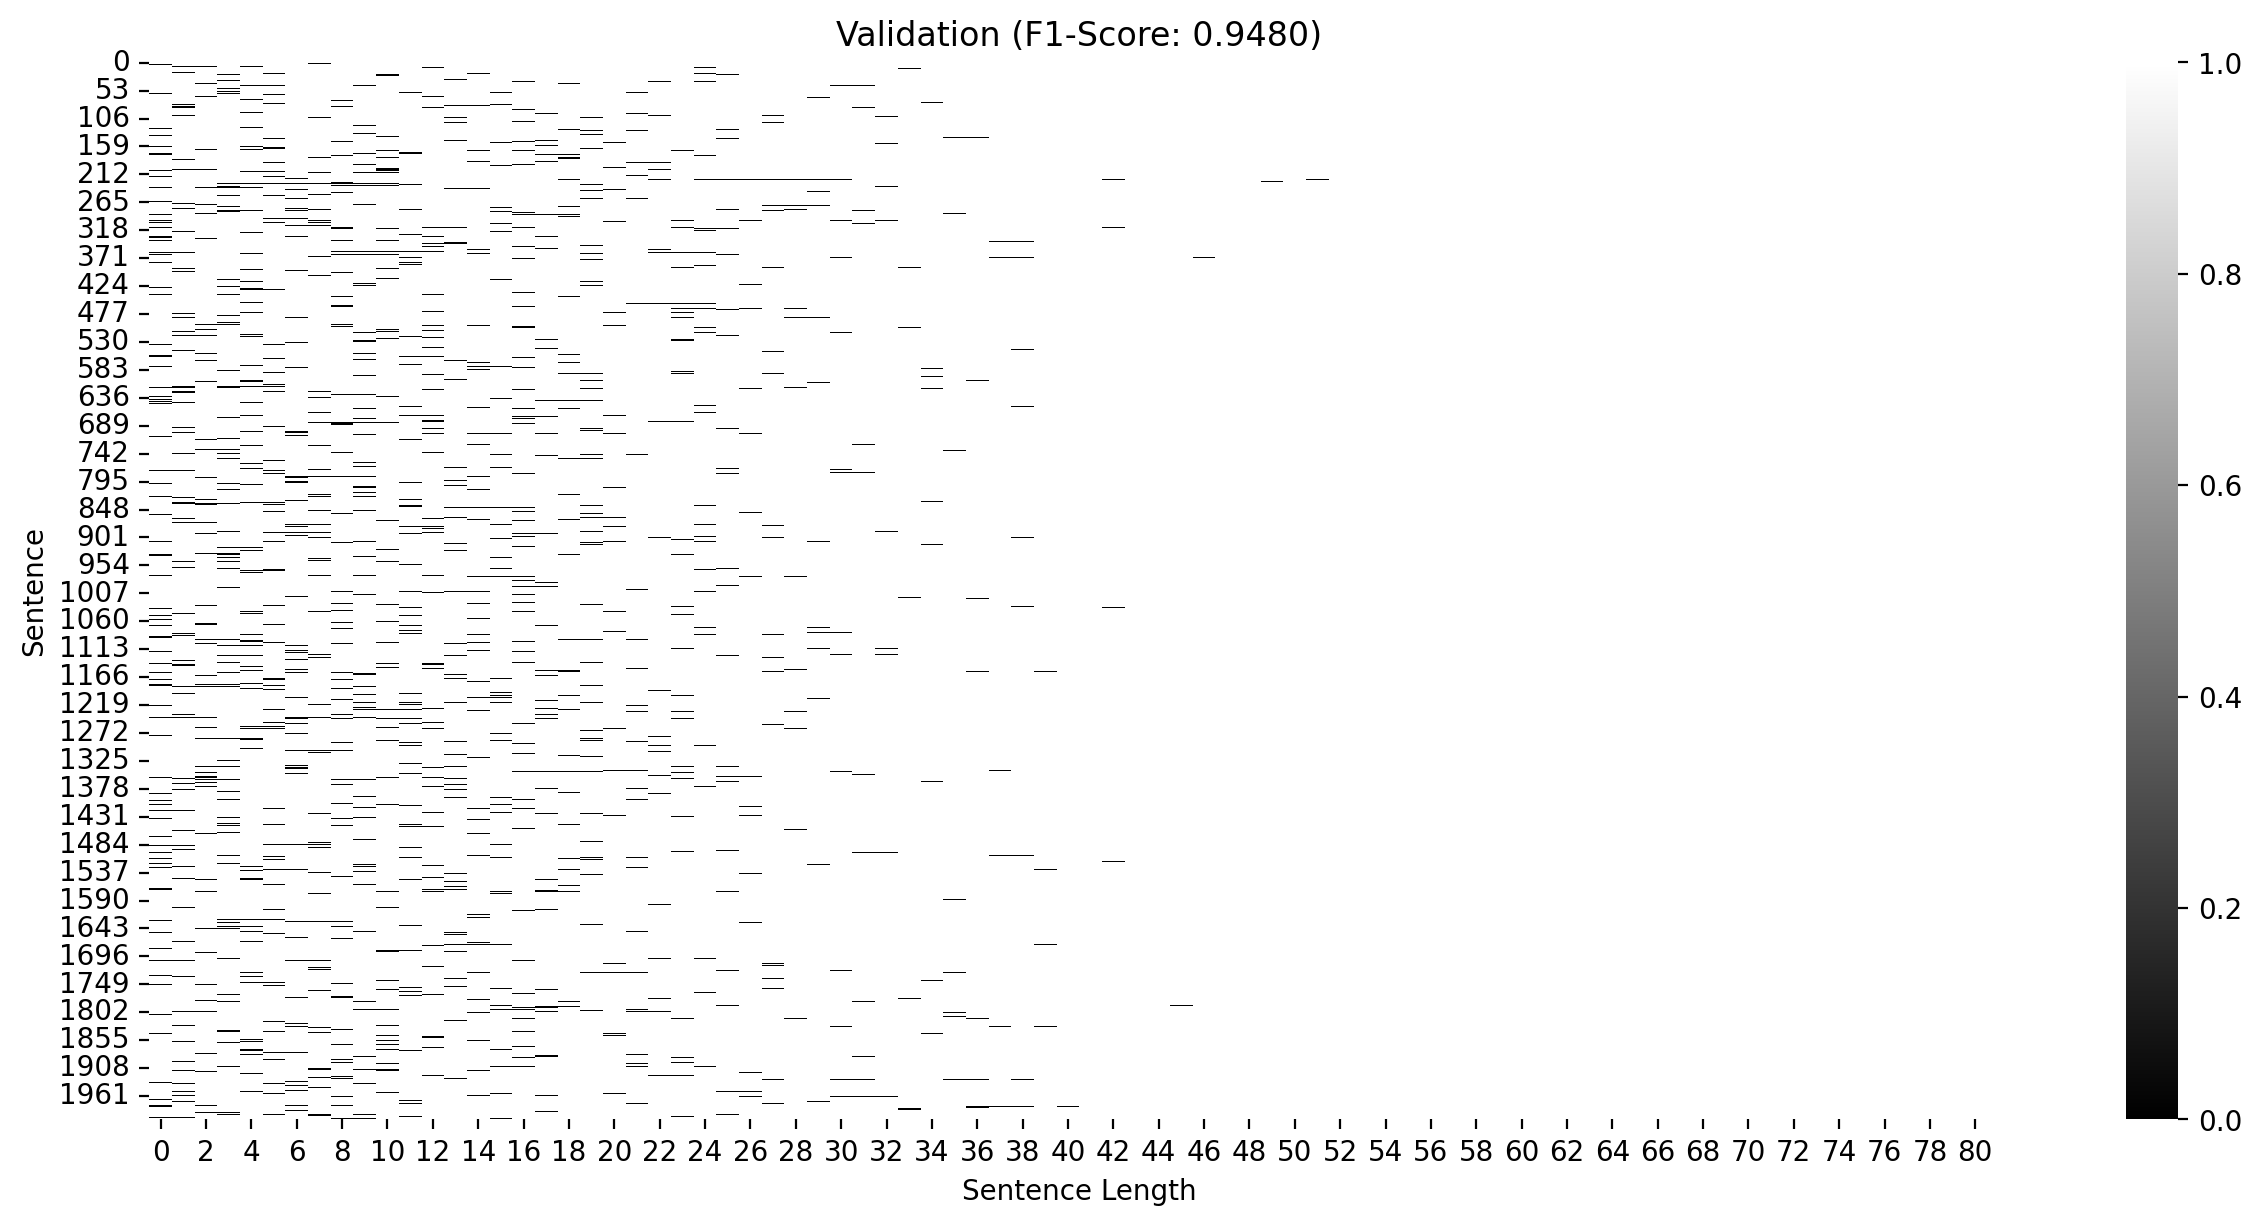

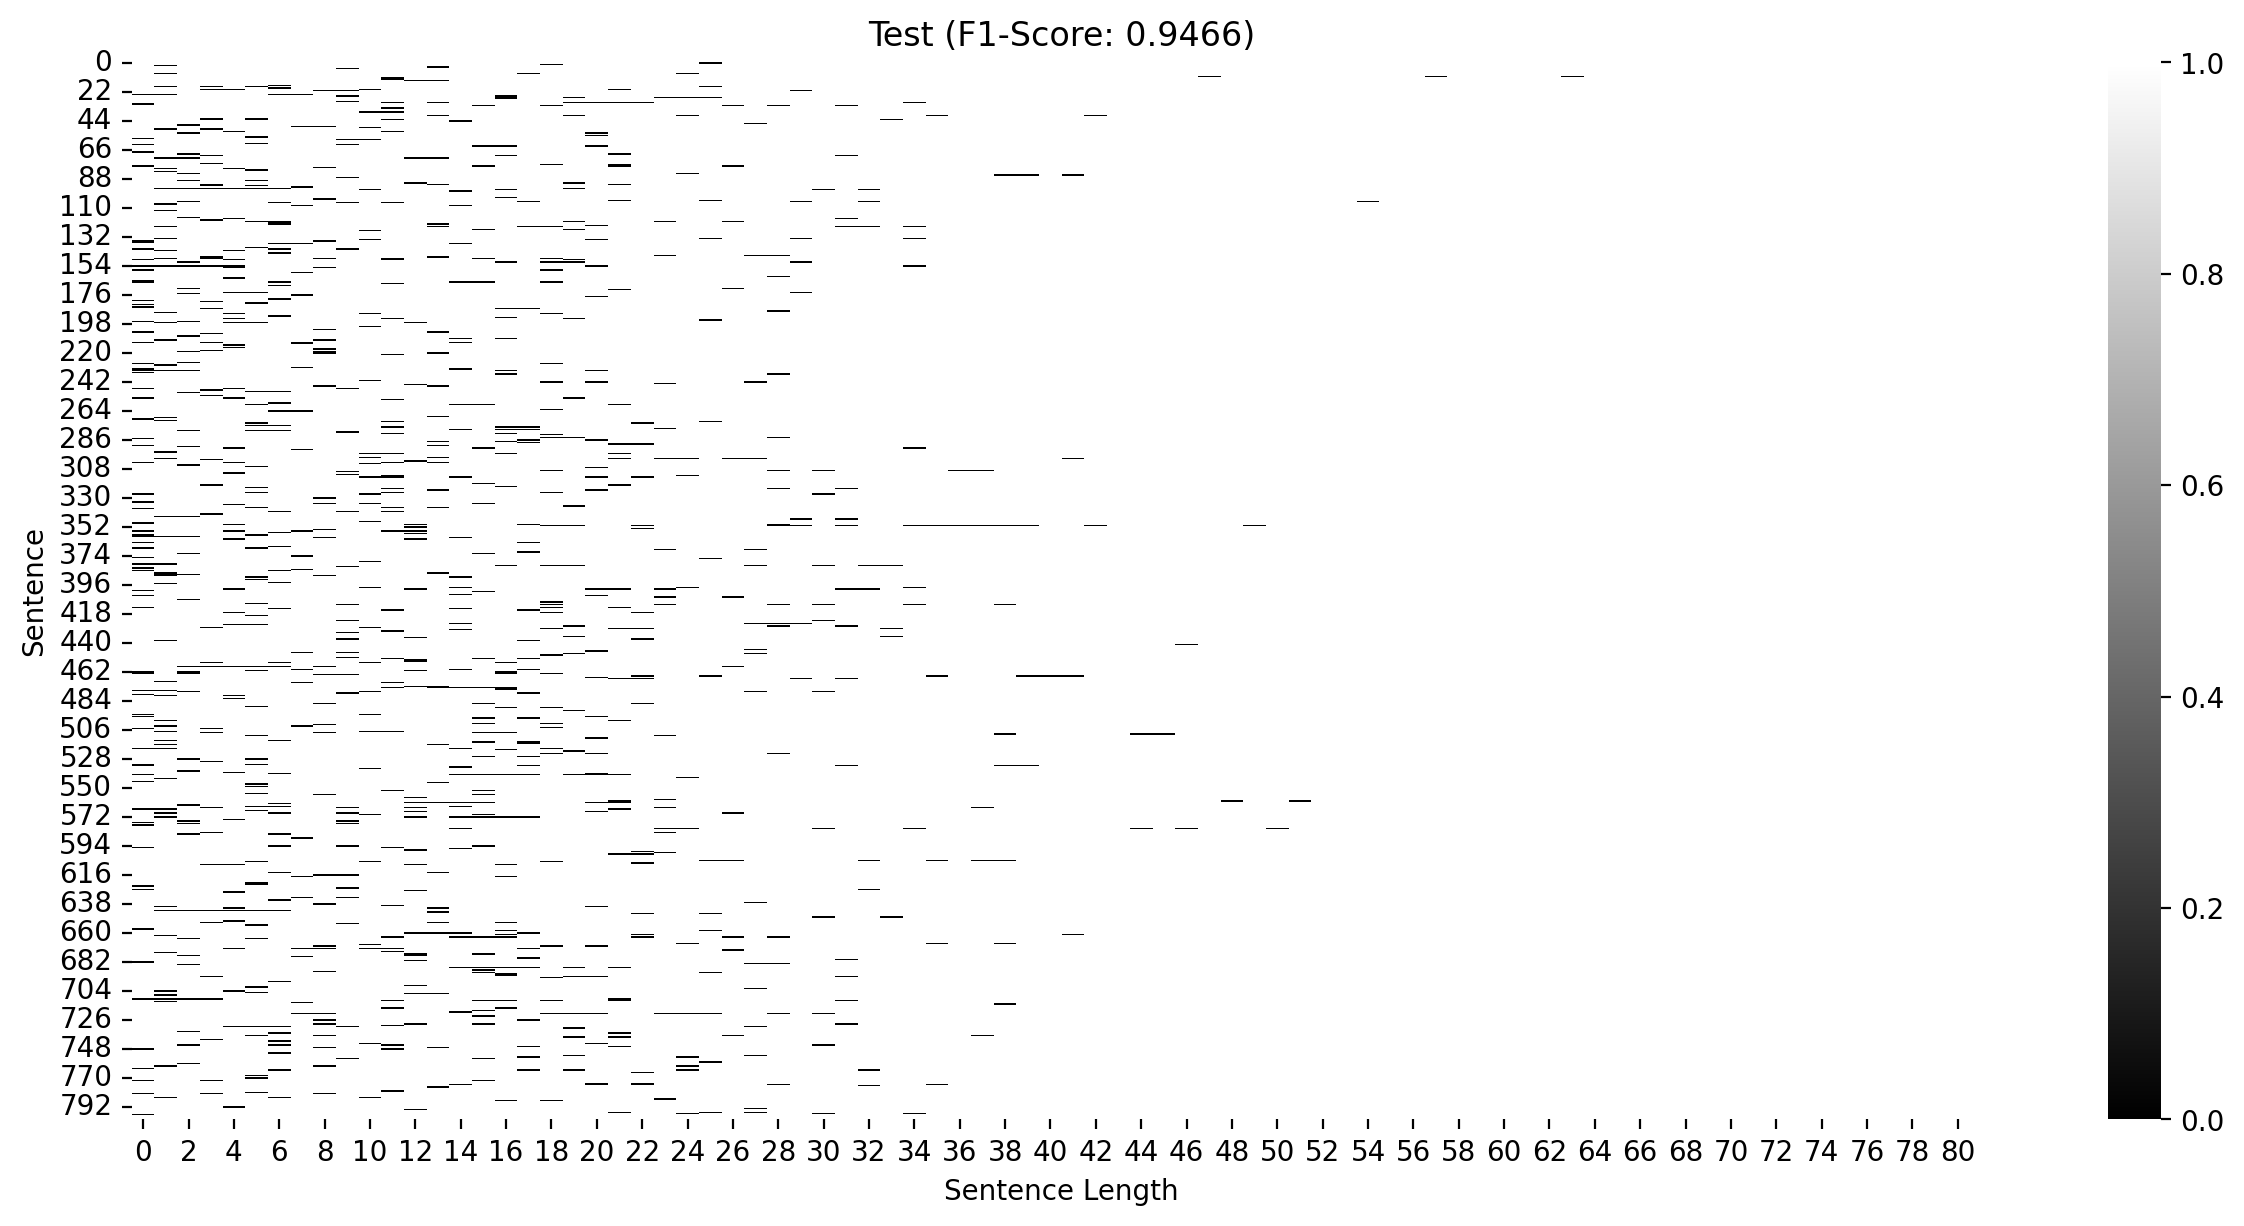

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 96 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 120 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


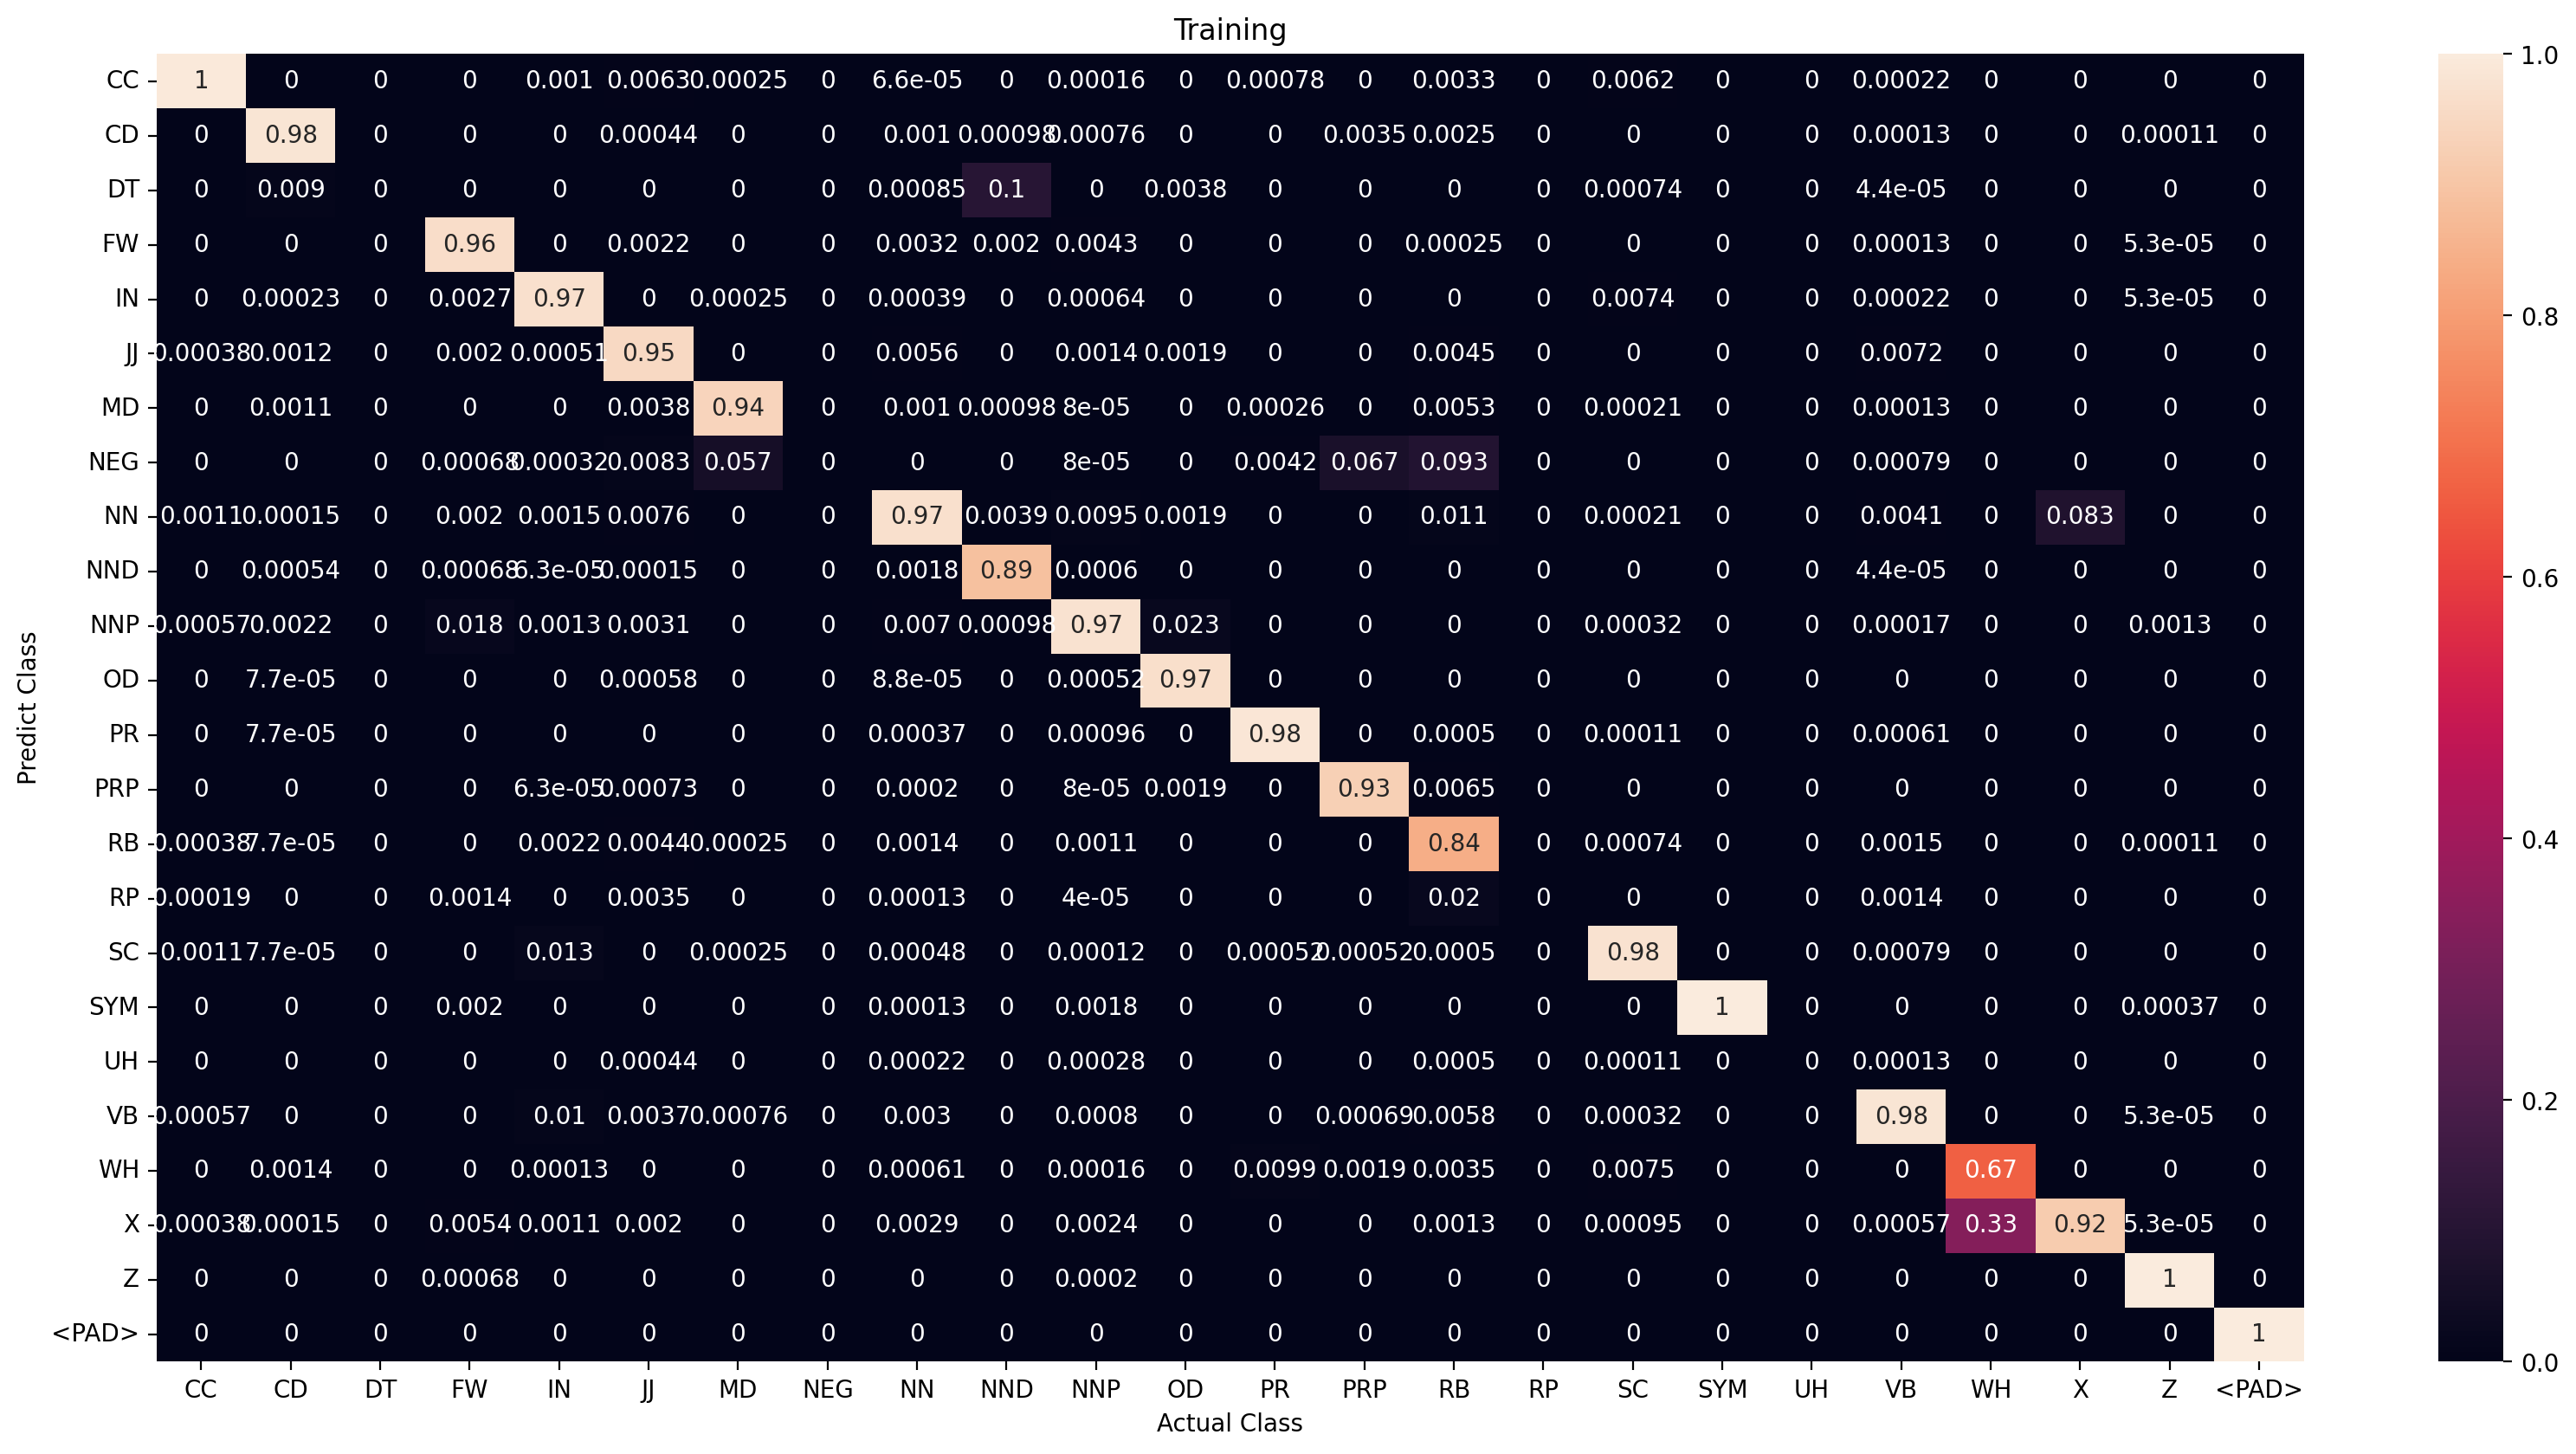

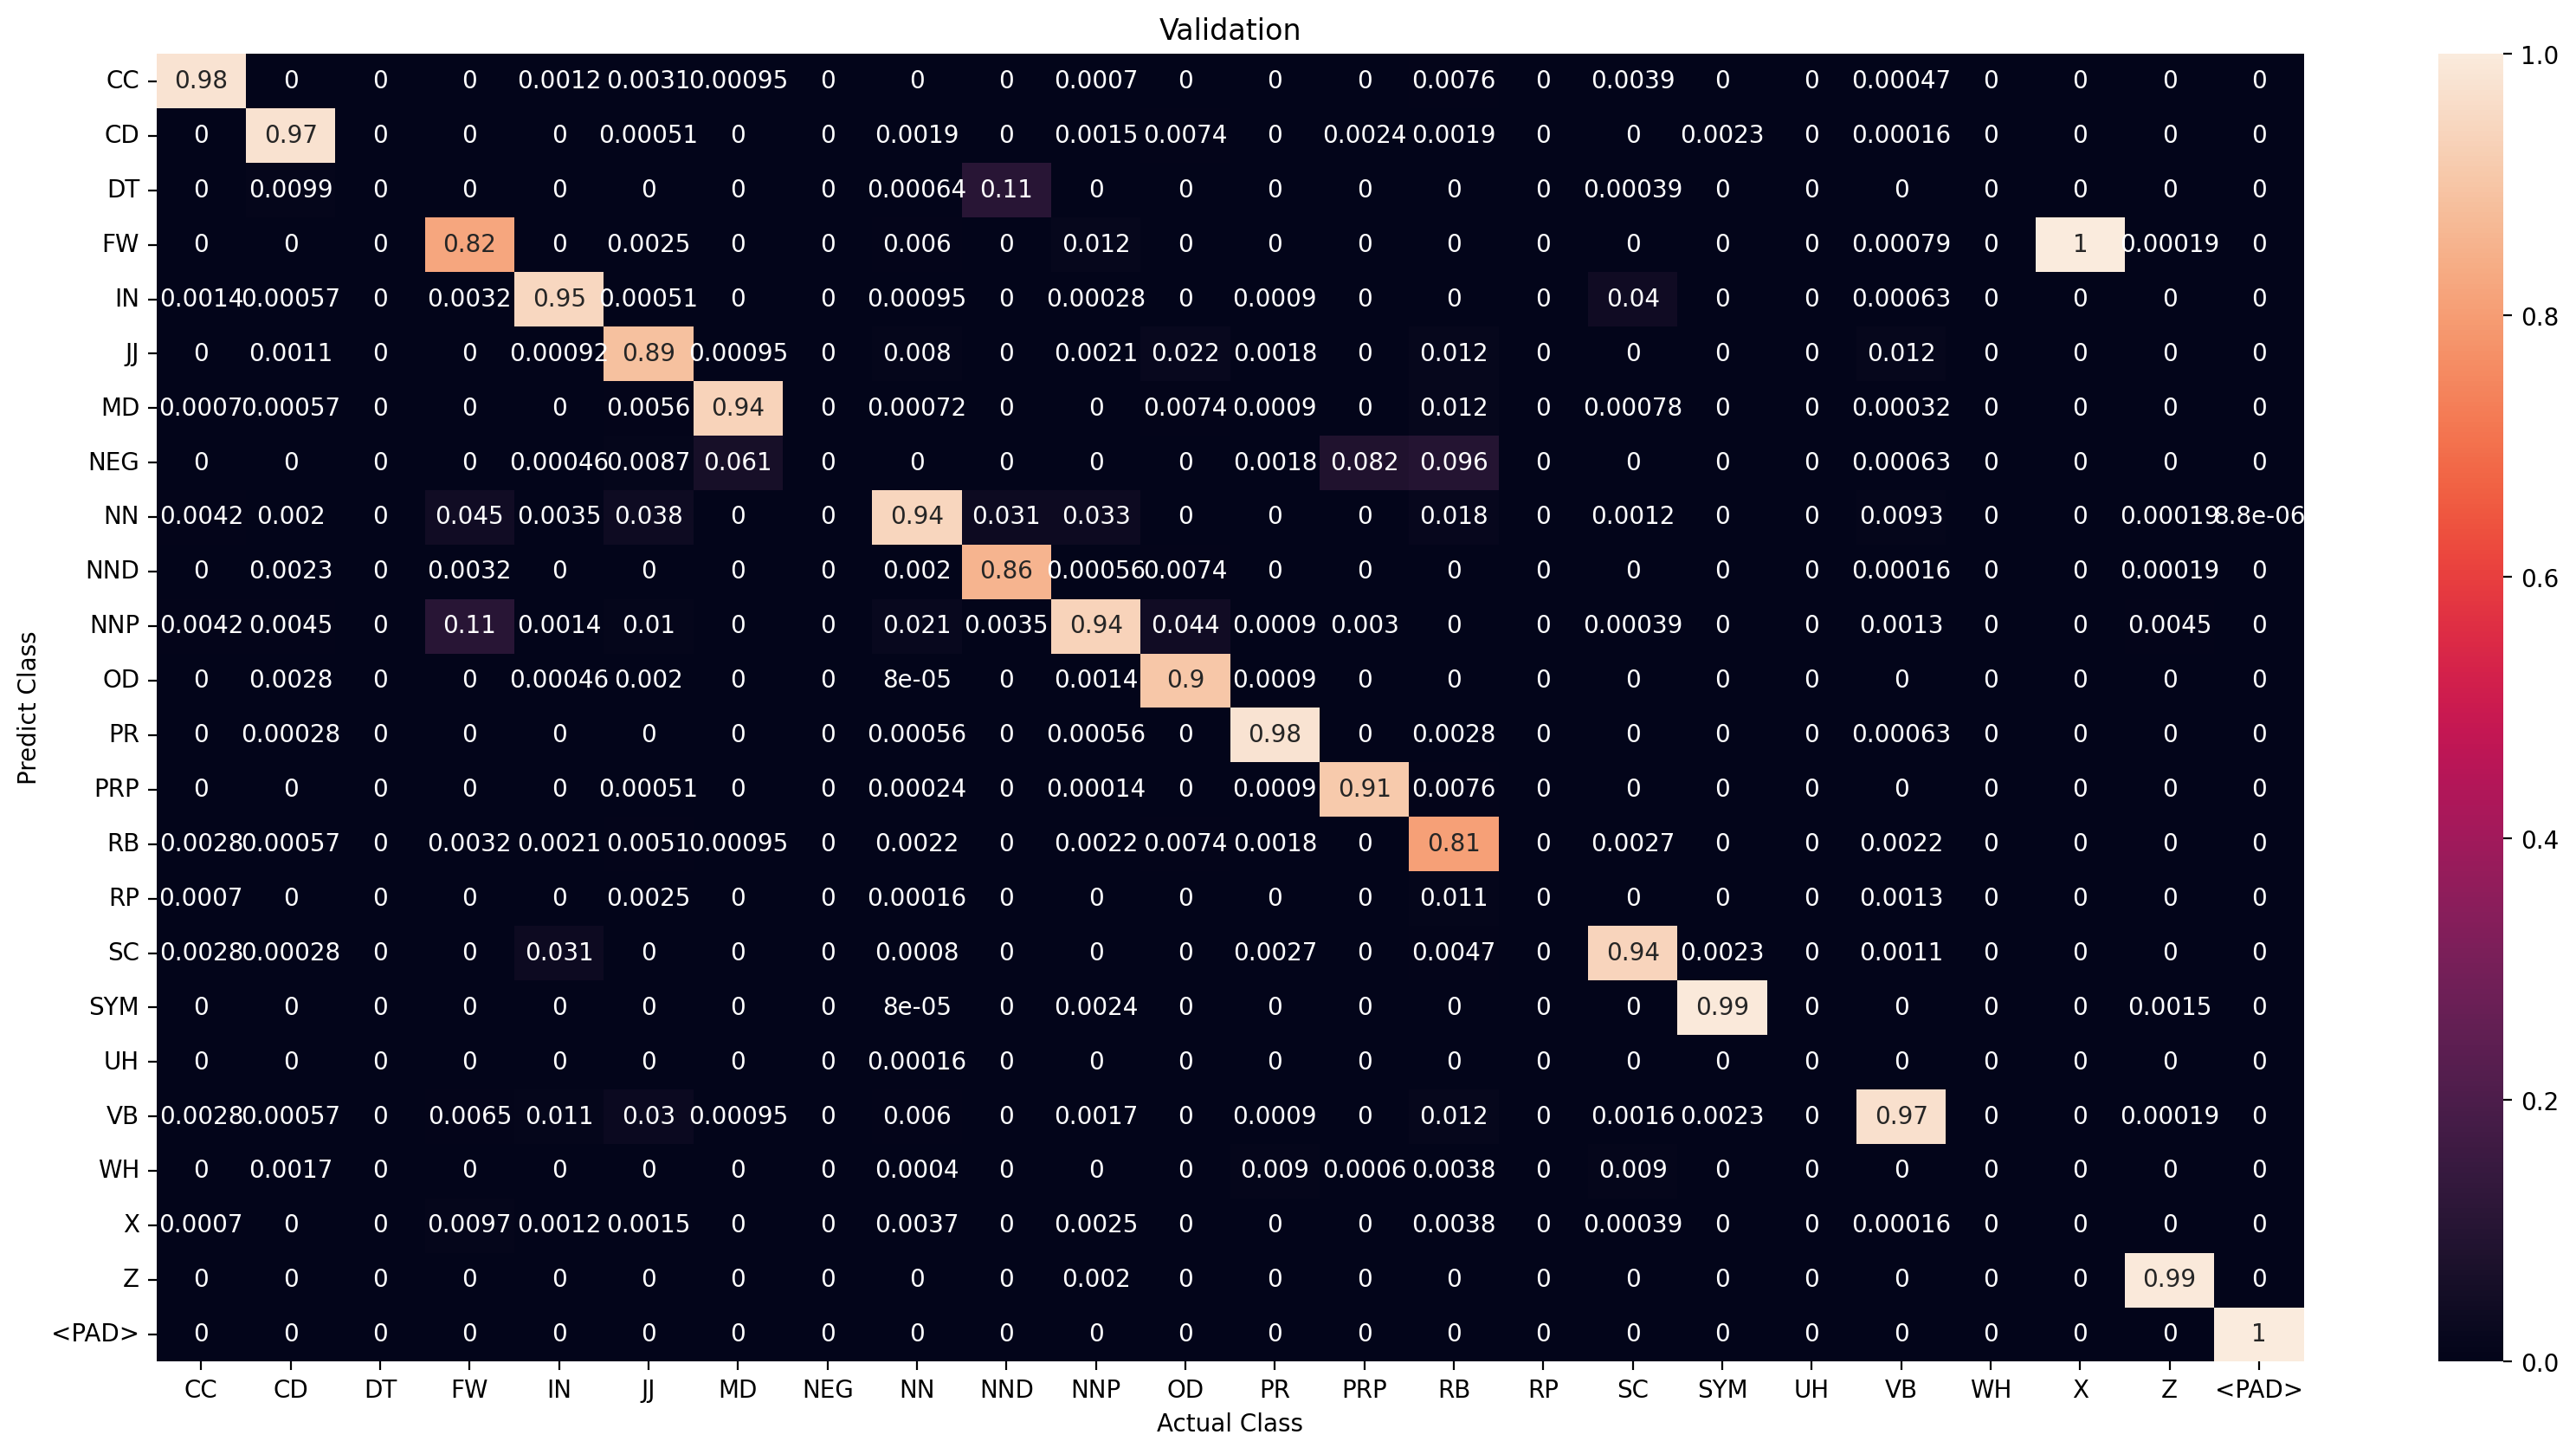

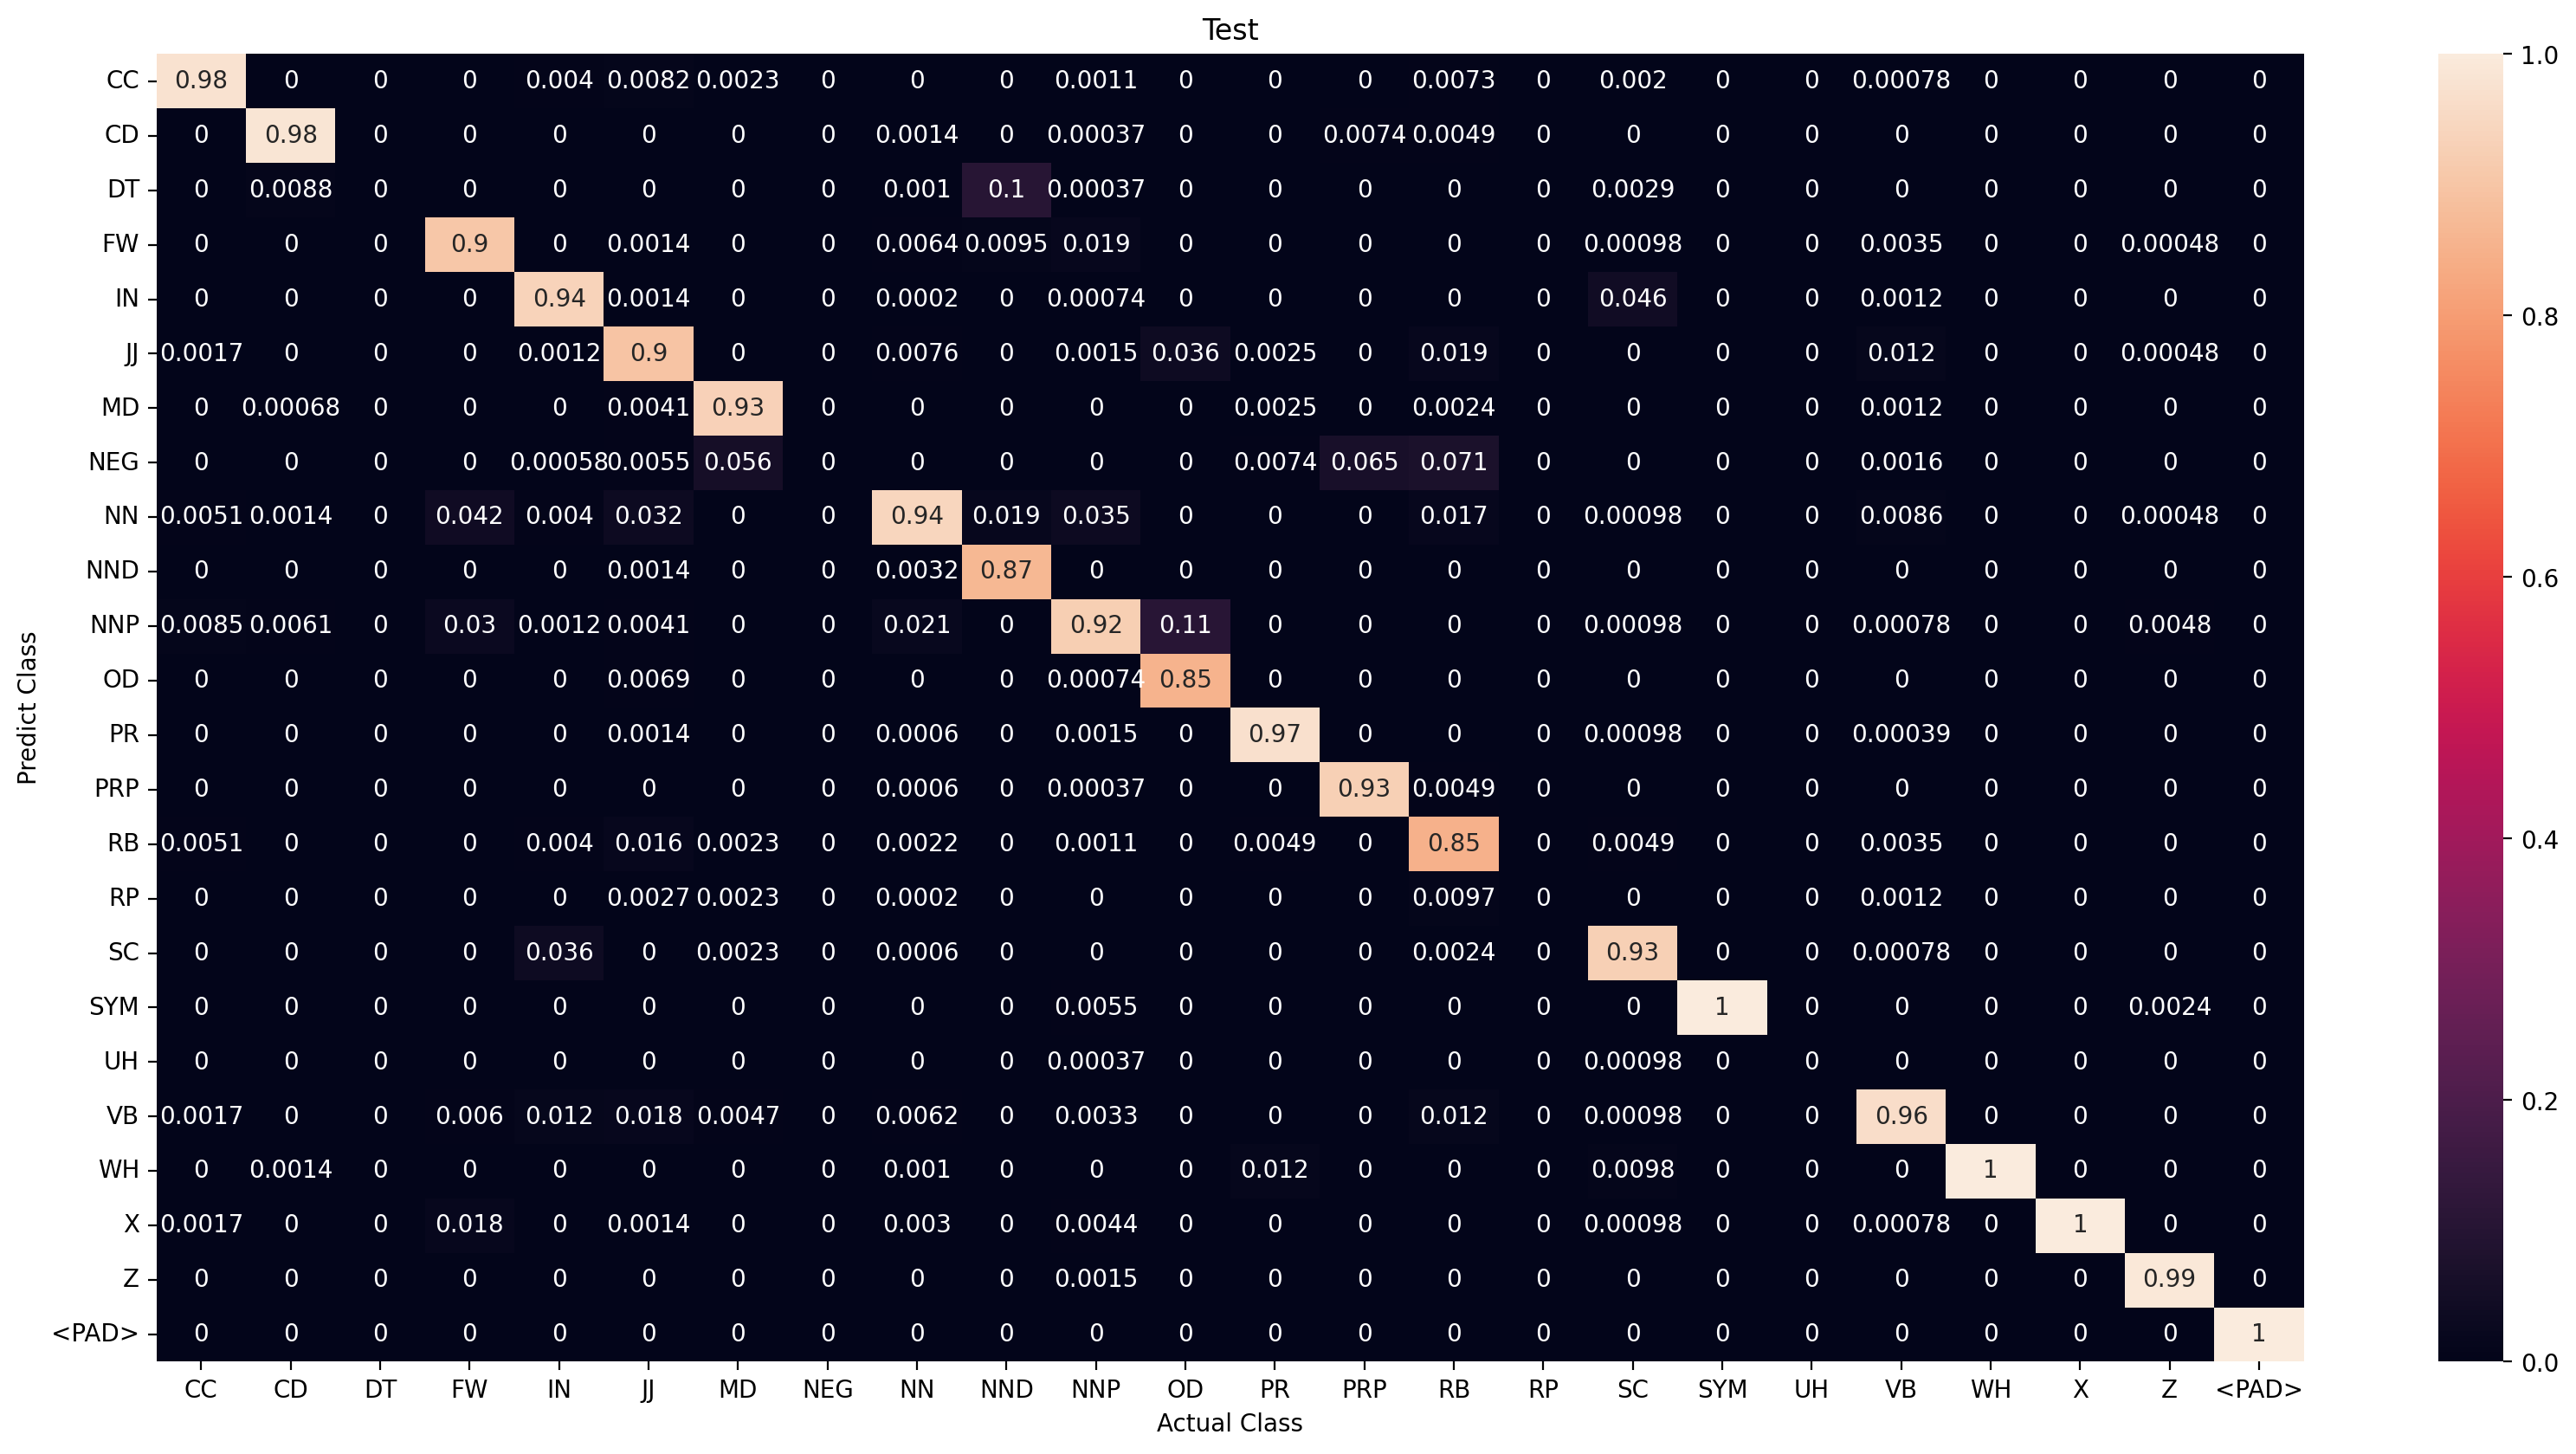

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5391   | CC    : 5244       | CC    : 147      |
| CD    : 12882  | CD    : 12777      | CD    : 105      |
| DT    : 273    | DT    : 0          | DT    : 273      |
| FW    : 1690   | FW    : 1415       | FW    : 275      |
| IN    : 15403  | IN    : 15285      | IN    : 118      |
| JJ    : 7018   | JJ    : 6516       | JJ    : 502      |
| MD    : 3810   | MD    : 3694       | MD    : 116      |
| NEG   : 1082   | NEG   : 0          | NEG   : 1082     |
| NN    : 44728  | NN    : 44261      | NN    : 467      |
| NND   : 1019   | NND   : 909        | NND   : 110      |
| NNP   : 24885  | NNP   : 24420      | NNP   : 465      |
| OD    : 534    | OD    : 512        | OD    : 22       |
| PR    : 3842   | PR    : 3783       | PR    : 59       |
| PRP   : 5405   | PRP   : 5361       | PRP   : 44       |
| RB    : 3553   | RB    : 3352       | RB    : 201      |
| RP    : 144    | RP    : 0          | RP    : 144     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11808
Correct prediction          : 11045
Wrong prediction            : 763
Percentage correct oov pred : 93.53827913279133

Validation
Number OOV token            : 3395
Correct prediction          : 2983
Wrong prediction            : 412
Percentage correct oov pred : 87.86450662739323

Test
Number OOV token            : 1359
Correct prediction          : 1186
Wrong prediction            : 173
Percentage correct oov pred : 87.2700515084621



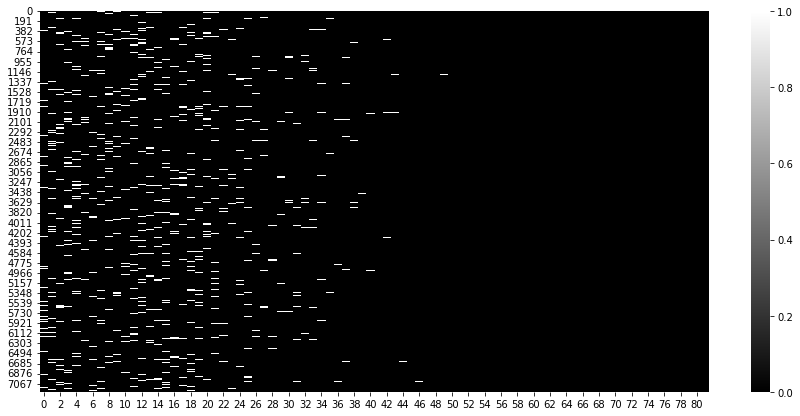

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

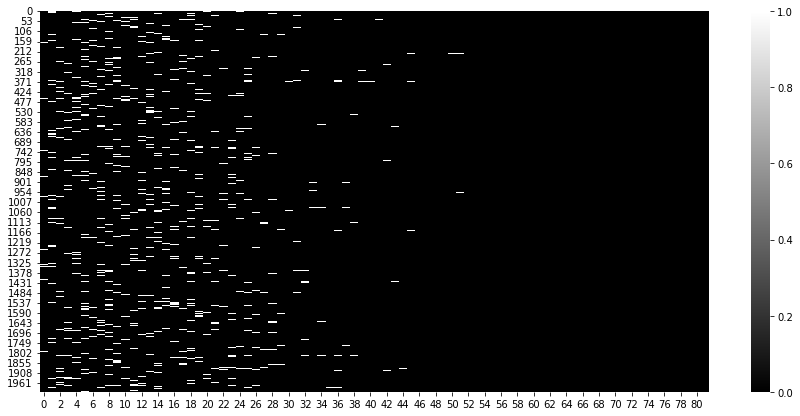

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

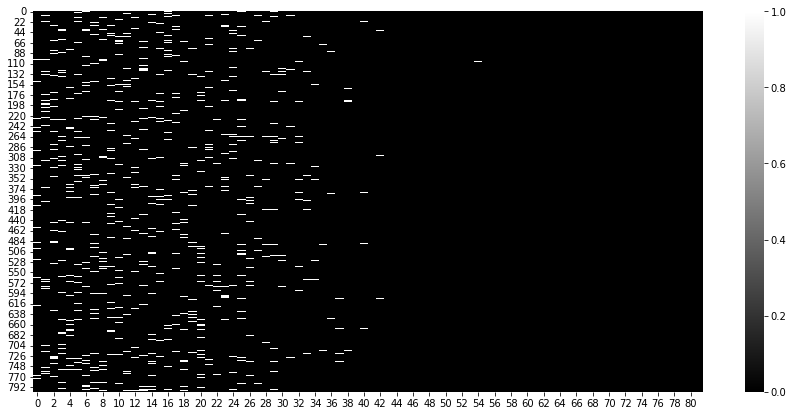

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);